# Imports

In [1]:
import os
import urllib
import sys
import tarfile
import datetime
import shutil
import copy
import random
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import models, optimizers

from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from random import sample
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from PIL import Image
from torch.nn.functional import normalize

from itertools import combinations
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

# Select GPU 5 for training
device = torch.device("cuda:5" if torch.cuda.is_available() else "CPU")
print('Torch device:', device)

2025-01-15 14:17:20.330950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 14:17:20.355407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 14:17:20.363064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 14:17:20.382471: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 14:17:22.727329: W tensorflow/compiler/tf2

Torch device: cuda:5


# Function Definitions

## Data Loading and Preprocessing

In [2]:
def load_and_preprocess_image(img_path,image_size=(160,160)):
    preprocess = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    img = Image.open(img_path).convert('RGB')
    img = preprocess(img)

    return img

In [3]:
# Map person names to integer labels
def map_labels_to_int(dataframe):
    label_to_int = {label: idx for idx, label in enumerate(dataframe['person'].unique())}
    dataframe['labels'] = dataframe['person'].map(label_to_int)
    return dataframe

## Data Splits

In [4]:
# Split train_dataset person-wise (ensuring no person is in both train and test sets)
def person_wise_train_test_split(train_dataset, test_size=0.2):
    unique_persons = train_dataset['person'].unique()
    unique_persons = unique_persons[unique_persons != 'elephant']
    train_persons, test_persons = train_test_split(unique_persons, test_size=test_size, random_state=42)
    train_data = train_dataset[train_dataset['person'].isin(train_persons)].reset_index(drop=True)
    test_data = train_dataset[train_dataset['person'].isin(test_persons)].reset_index(drop=True)

    return train_data, test_data

## Helper Functions (accuracy, embeddings)

In [5]:
# Function to get embeddings batchwise, avoids memory issues
def get_batch_embeddings(data_df, model, device=device, batch_size=32):
    preprocess = transforms.Compose([
        transforms.Resize((160, 160)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    model.eval()
    embeddings = []

    for i in range(0, len(data_df), batch_size):
        batch_df = data_df.iloc[i:i + batch_size]
        images = []
        for img_path in batch_df['path']:
            img = Image.open(img_path).convert('RGB')
            img = preprocess(img)
            images.append(img)

        batch_images = torch.stack(images).to(device)

        with torch.no_grad():
            batch_embeddings = model(batch_images)
            
        embeddings.append(batch_embeddings)

    embeddings = torch.cat(embeddings)
    return embeddings

In [6]:
def calculate_accuracy(embeddings, test_df, threshold=1.242):
    correct_predictions = 0
    total_comparisons = 0
    
    num_images = embeddings.shape[0]
    
    for i in range(num_images):
        for j in range(i + 1, num_images):
            label1 = test_df.iloc[i]['labels']
            label2 = test_df.iloc[j]['labels']
            
            distance = torch.norm(embeddings[i] - embeddings[j]).item()

            if (label1 == label2 and distance < threshold) or (label1 != label2 and distance >= threshold):
                correct_predictions += 1
            
            total_comparisons += 1

    accuracy = correct_predictions / total_comparisons if total_comparisons > 0 else 0
    print(f'Accuracy: {accuracy * 100:.2f}%')

    return accuracy

In [7]:
def find_optimal_threshold(data, model, labels, distance_metric='euclidean', num_thresholds=100):
    embeddings =  get_batch_embeddings(data, model, device=device, batch_size=32).cpu().numpy()
    distances = cdist(embeddings, embeddings, metric=distance_metric)
    pairwise_labels = (labels[:, None] == labels[None, :]).astype(int)
    distances_flat = distances[np.triu_indices(len(distances), k=1)]
    labels_flat = pairwise_labels[np.triu_indices(len(pairwise_labels), k=1)]
    thresholds = np.linspace(distances_flat.min(), distances_flat.max(), num_thresholds)
    accuracies = []
    
    for threshold in thresholds:
        preds = (distances_flat <= threshold).astype(int)
        accuracies.append(accuracy_score(labels_flat, preds))
    
    optimal_idx = np.argmax(accuracies)
    optimal_threshold = thresholds[optimal_idx]
    best_accuracy = accuracies[optimal_idx]

    return optimal_threshold, best_accuracy

## Model Architecture

In [8]:
class CustomInceptionResnet(torch.nn.Module):
    def __init__(self, pretrained='casia-webface', classify=False, device='cpu'):
        super(CustomInceptionResnet, self).__init__()
        
        # Load the pretrained InceptionResnetV1 model
        self.resnet = InceptionResnetV1(pretrained=pretrained, classify=classify).to(device)
        
        # Add a new 128-unit dense layer
        self.dense = torch.nn.Linear(self.resnet.last_linear.out_features, 128)

    def freeze_backbone(self):
        """Freeze the backbone model to train only the dense layer."""
        for param in self.resnet.parameters():
            param.requires_grad = False
    
    def unfreeze_backbone(self):
        """Unfreeze the backbone model for fine-tuning."""
        for param in self.resnet.parameters():
            param.requires_grad = True
            
    def forward(self, x):
        x = self.resnet(x)
        x = self.dense(x)
        x = F.normalize(x, p=2, dim=1)
        return x

## Train Functions

In [9]:
def _pairwise_distances(embeddings, squared=True):
    dot_product = torch.matmul(embeddings, embeddings.T)
    square_norm = torch.diagonal(dot_product)
    distances = square_norm.unsqueeze(1) - 2.0 * dot_product + square_norm.unsqueeze(0)
    distances = torch.clamp(distances, min=0.0)

    if not squared:
        mask = (distances == 0.0).float()
        distances += mask * 1e-16
        distances = torch.sqrt(distances)
        distances *= (1.0 - mask)

    return distances

In [10]:
def _get_triplet_mask(labels):
    batch_size = labels.size(0)
    indices_equal = torch.eye(batch_size, dtype=torch.bool, device=labels.device)
    indices_not_equal = ~indices_equal
    i_not_equal_j = indices_not_equal.unsqueeze(2)
    i_not_equal_k = indices_not_equal.unsqueeze(1)
    j_not_equal_k = indices_not_equal.unsqueeze(0)
    distinct_indices = i_not_equal_j & i_not_equal_k & j_not_equal_k
    label_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
    i_equal_j = label_equal.unsqueeze(2)
    i_equal_k = label_equal.unsqueeze(1)
    valid_labels = i_equal_j & ~i_equal_k
    mask = distinct_indices & valid_labels
    return mask

In [11]:
def batch_all_triplet_loss(labels, embeddings, margin=0.2, squared=True):
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)  
    anchor_positive_dist = pairwise_dist.unsqueeze(2)
    anchor_negative_dist = pairwise_dist.unsqueeze(1)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin
    mask = _get_triplet_mask(labels)
    mask = mask.float()
    triplet_loss = triplet_loss * mask
    triplet_loss = torch.maximum(triplet_loss, torch.tensor(0.0, device=triplet_loss.device))
    valid_triplets = triplet_loss > 1e-16
    num_positive_triplets = valid_triplets.sum().float()
    num_valid_triplets = mask.sum().float()
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)
    triplet_loss = triplet_loss.sum() / (num_positive_triplets + 1e-16)

    return triplet_loss

In [12]:
def get_batches(train_data_greater_than_five, remaining_data, batch_size=64, image_size=(160, 160)):
    persons_per_batch = 16  # Number of person groups per batch (each group has 3 images)
    images_per_group = 3  # Fixed number of images per person group
    shuffled_train_data = train_data_greater_than_five.sample(frac=1).reset_index(drop=True)
    unique_persons = shuffled_train_data['labels'].unique()
    num_persons = len(unique_persons)
    person_groups = []
    for person in unique_persons:
        person_images = shuffled_train_data[shuffled_train_data['labels'] == person]
        for i in range(0, len(person_images), images_per_group):
            group = person_images.iloc[i:i + images_per_group]
            if len(group) == images_per_group:
                person_groups.append(group)

    
    np.random.shuffle(person_groups)
    num_batches = int(np.ceil(len(person_groups) / persons_per_batch))
    used_remaining_indices = set()

    for batch_idx in range(num_batches):
        start_idx = batch_idx * persons_per_batch
        end_idx = min(start_idx + persons_per_batch, len(person_groups))
        batch_groups = person_groups[start_idx:end_idx]
        batch_images = []
        batch_labels = []
        for group in batch_groups:
            for img_path in group['path']:
                img_array = load_and_preprocess_image(img_path, image_size=image_size)
                batch_images.append(img_array)
            batch_labels.extend(group['labels'].tolist())

        num_remaining_images = batch_size - len(batch_images)
        if num_remaining_images > 0:
            available_indices = set(range(len(remaining_data))) - used_remaining_indices

            if len(available_indices) < num_remaining_images:
                raise ValueError("Not enough unique images in remaining_data to fill the batch")

            selected_indices = np.random.choice(list(available_indices), size=num_remaining_images, replace=False)
            used_remaining_indices.update(selected_indices)

            remaining_samples = remaining_data.iloc[selected_indices]

            for img_path in remaining_samples['path']:
                img_array = load_and_preprocess_image(img_path, image_size=image_size)
                batch_images.append(img_array)

            batch_labels.extend(remaining_samples['labels'].tolist())

        batch_images = torch.stack(batch_images).to(device)
        batch_labels = np.array(batch_labels)

        
        yield batch_images, batch_labels

In [13]:
def training_loop(model, train_data, remaining_train_data, test_data, remaining_test_data, optimizer, loss_fn, epochs=10, margin=0.2, batch_size=64, test_batch_size=64, device=device, log_dir="logs_facenet_train"):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = os.path.join(log_dir, current_time, 'train')
    test_log_dir = os.path.join(log_dir, current_time, 'test')
    train_summary_writer = SummaryWriter(train_log_dir)
    test_summary_writer = SummaryWriter(test_log_dir)
    model.to(device)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        train_loss_tracker = 0
        batch_count = 0

        train_batches = get_batches(train_data, remaining_train_data, batch_size=batch_size, image_size=(160, 160))
        for images, labels in train_batches:
            labels = torch.tensor(labels).to(device)

            optimizer.zero_grad()
            embeddings = model(images)
            loss = loss_fn(labels, embeddings, margin=margin)
            loss.backward()
            optimizer.step()

            train_loss_tracker += loss.item()
            batch_count += 1

        avg_train_loss = train_loss_tracker / batch_count
        train_summary_writer.add_scalar('loss', avg_train_loss, epoch)

        print(f"Training loss at epoch {epoch+1}: {avg_train_loss:.4f}")

        model.eval()
        test_loss_tracker = 0
        test_batch_count = 0

        test_batches = get_batches(test_data, remaining_test_data, batch_size=test_batch_size, image_size=(160, 160))
        with torch.no_grad(): 
            for test_images, test_labels in test_batches:
                test_labels = torch.tensor(test_labels).to(device)

                test_embeddings = model(test_images) 
                test_loss = loss_fn(test_labels, test_embeddings)

                test_loss_tracker += test_loss.item()
                test_batch_count += 1

        avg_test_loss = test_loss_tracker / test_batch_count
        test_summary_writer.add_scalar('loss', avg_test_loss, epoch)

        print(f"Test loss at epoch {epoch+1}: {avg_test_loss:.4f}")

    return model


## Unlearn Functions

In [14]:
def unlearning_loss(anchor, positive, negative, alpha=5, multiply=2):
    pos_dist = torch.square(torch.norm(anchor - positive, dim=1))
    neg_dist = torch.square(torch.norm(anchor - negative, dim=1))
    basic_loss = neg_dist - multiply*pos_dist + alpha
    loss = torch.clamp(basic_loss, min=0.0)
    return torch.mean(loss)

In [15]:
def get_batches_forget(forget_data_class, retain_data, batch_size=64, image_size=(160, 160)):
    global used_negative_indices
    forget_pairs = []
    num_images = len(forget_data_class)
    
    for i in range(num_images):
        for j in range(num_images):
            if i != j:
                forget_pairs.append((forget_data_class.iloc[i]['path'], forget_data_class.iloc[j]['path']))
    
    num_batches = len(forget_pairs) // batch_size
    remaining_pairs = len(forget_pairs) % batch_size
    np.random.shuffle(forget_pairs)
    
    total_negative_samples_needed = batch_size * num_batches + (remaining_pairs if remaining_pairs > 0 else 0)
    
    available_indices = retain_data.index
    if len(available_indices) < total_negative_samples_needed:
        raise ValueError("Not enough unique negative samples in retain_data for the entire epoch")

    sampled_negative_indices = np.random.choice(available_indices, total_negative_samples_needed, replace=False)
    used_negative_indices.update(sampled_negative_indices)
    
    sampled_negative_paths = retain_data['path'].iloc[sampled_negative_indices].tolist()
    sampled_negative_images = [load_and_preprocess_image(path, image_size=image_size) for path in sampled_negative_paths]
    
    negative_idx = 0
    for batch_idx in range(num_batches):
        batch_anchors = []
        batch_positives = []
        batch_negatives = []

        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        batch_pairs = forget_pairs[start_idx:end_idx]

        for anchor_path, positive_path in batch_pairs:
            anchor_image = load_and_preprocess_image(anchor_path, image_size=image_size)
            positive_image = load_and_preprocess_image(positive_path, image_size=image_size)
            negative_image = sampled_negative_images[negative_idx]
            negative_idx += 1
            batch_anchors.append(anchor_image)
            batch_positives.append(positive_image)
            batch_negatives.append(negative_image)

        batch_anchors = torch.stack(batch_anchors).to(device)
        batch_positives = torch.stack(batch_positives).to(device)
        batch_negatives = torch.stack(batch_negatives).to(device)

        yield (batch_anchors, batch_positives, batch_negatives)

    if remaining_pairs > 0:
        batch_anchors = []
        batch_positives = []
        batch_negatives = []

        for anchor_path, positive_path in forget_pairs[-remaining_pairs:]:
            anchor_image = load_and_preprocess_image(anchor_path, image_size=image_size)
            positive_image = load_and_preprocess_image(positive_path, image_size=image_size)
            negative_image = sampled_negative_images[negative_idx]
            negative_idx += 1

            batch_anchors.append(anchor_image)
            batch_positives.append(positive_image)
            batch_negatives.append(negative_image)

        batch_anchors = torch.stack(batch_anchors).to(device)
        batch_positives = torch.stack(batch_positives).to(device)
        batch_negatives = torch.stack(batch_negatives).to(device)

        yield (batch_anchors, batch_positives, batch_negatives)


In [16]:
def unlearning_training_loop(model_train, forget_data_class, optimizer, unlearning_loss_fn, retain_data_greater_than_three, epochs=10, margin=1.3, multiply=2):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        model_train.train()

        train_loss_tracker = 0.0

        batches = get_batches_forget(forget_data_class, retain_data_greater_than_three)

        batch_count=0

        for anchor, positive, negative in batches:
            optimizer.zero_grad()

            anchor_embedding = model_train(anchor)
            positive_embedding = model_train(positive)
            negative_embedding = model_train(negative)

            unlearning_loss = unlearning_loss_fn(anchor_embedding, positive_embedding, negative_embedding, margin, multiply)

            unlearning_loss.backward()
            optimizer.step()

            train_loss_tracker += unlearning_loss.item()
            batch_count+=1

        avg_train_loss = train_loss_tracker / batch_count
        print(f"Training loss at epoch {epoch+1}: {avg_train_loss}")

    return model_train

## Repair Functions

In [17]:
# -----------------------------------------
# Repair loop and get_batches same as train
# -----------------------------------------
# ---------------------------------
# Selecting most damaged identities
# ---------------------------------

In [18]:
def compute_representative_dataset(retain_data_class, embeddings_retain, mean_forget_embedding, preselected_indices, device2, n_closest_points=3, device='cpu'):
    embeddings_retain = embeddings_retain.to(device)
    mean_forget_embedding = mean_forget_embedding.to(device)
    unique_identities = retain_data_class['person'].nunique()
    n_clusters = max(1, unique_identities // 3)
    # DENSITY BASED SELECTION
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
    kde.fit(embeddings_retain.cpu().numpy())
    log_density_scores = kde.score_samples(embeddings_retain.cpu().numpy())
    density_scores = torch.exp(torch.tensor(log_density_scores, device=device))
    low_density_threshold = torch.quantile(density_scores, 0.1)
    high_density_threshold = torch.quantile(density_scores, 0.9)
    low_density_indices = torch.where(density_scores <= low_density_threshold)[0]
    high_density_indices = torch.where(density_scores >= high_density_threshold)[0]
    num_low_density = min(10, len(low_density_indices))
    num_high_density = min(10, len(high_density_indices))

    selected_low_density_indices = sample(low_density_indices.tolist(), num_low_density)
    selected_high_density_indices = sample(high_density_indices.tolist(), num_high_density)

    # DIVERSITY BASED SELECTION (K-Means clustering)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(embeddings_retain.cpu().numpy())
    cluster_centers = torch.tensor(kmeans.cluster_centers_, device=device)
    cluster_labels = torch.tensor(kmeans.labels_, device=device)
    closest_points = []
    for cluster_idx in range(n_clusters):
        cluster_points_indices = torch.where(cluster_labels == cluster_idx)[0]
        cluster_points = embeddings_retain[cluster_points_indices]
    
        num_points_in_cluster = cluster_points.shape[0]
        if num_points_in_cluster == 0:
            continue 
        center = cluster_centers[cluster_idx].unsqueeze(0) 
        distances = torch.norm(cluster_points - center, dim=1)
    
        n_points_to_select = min(n_closest_points, num_points_in_cluster) 
        closest_indices_in_cluster = distances.topk(n_points_to_select, largest=False).indices
        closest_points.extend(cluster_points_indices[closest_indices_in_cluster].tolist())

    # INSTANCES CLOSE TO THE MEAN EMBEDDING OF FORGET IDENTITY
    distances_to_forget_mean = torch.norm(embeddings_retain - mean_forget_embedding, dim=1)
    closest_to_forget_indices = distances_to_forget_mean.topk(5, largest=False).indices
    representative_indices = set(selected_low_density_indices +
                                 selected_high_density_indices +
                                 closest_points +
                                 closest_to_forget_indices.tolist())
    
    representative_indices.update(preselected_indices)
    representative_indices = list(representative_indices)
    final_embeddings = embeddings_retain[representative_indices]
    final_representative_data = retain_data_class.iloc[representative_indices]
    unique_labels = final_representative_data['person'].unique()
    for label in unique_labels:
        same_identity_indices = retain_data_class.index[retain_data_class['person'] == label].tolist()
        same_identity_indices = list(set(same_identity_indices) - set(representative_indices))
        num_samples = min(3, len(same_identity_indices))
        if num_samples > 0:
            additional_indices = sample(same_identity_indices, num_samples)
            final_representative_data = pd.concat([final_representative_data, retain_data_class.iloc[additional_indices]])
            representative_indices.extend(additional_indices)

    final_embeddings = final_embeddings.to(device2)

    return final_representative_data#, final_embeddings


## Retain Functions

In [19]:
# ------------------------------------------
# Retrain loop and get_batches same as train
# ------------------------------------------

## Visualization

In [20]:
# --------------------------------------------------------------------------
# Function to visualize triplet embedding ratios of train, repair and retain
# and compute MSE between all embeddings of pairs of models
# --------------------------------------------------------------------------

def compare_triplet_embeddings(
    identities,
    model_train,
    model_repaired,
    model_retrained,
    n_plot=10
):
    with torch.no_grad():
        train_embeddings = get_batch_embeddings(identities, model_train).cpu().numpy()
        repaired_embeddings = get_batch_embeddings(identities, model_repaired).cpu().numpy()
        retrained_embeddings = get_batch_embeddings(identities, model_retrained).cpu().numpy()
    
    n_instances = len(identities)
    
    triplets = list(combinations(range(n_instances), 3))
    
    def compute_distance_ratio(embeddings, triplet):
        i1, i2, i3 = triplet
        d1 = euclidean(embeddings[i1], embeddings[i2])
        d2 = euclidean(embeddings[i1], embeddings[i3])
        return d1 / d2 if d2 != 0 else np.inf
    
    def compute_ratios(embeddings, triplets):
        return np.array([compute_distance_ratio(embeddings, triplet) for triplet in triplets])
    
    ratios_train = compute_ratios(train_embeddings, triplets)
    ratios_repaired = compute_ratios(repaired_embeddings, triplets)
    ratios_retrained = compute_ratios(retrained_embeddings, triplets)
    
    mse_train_vs_repaired = mean_squared_error(ratios_train, ratios_repaired)
    mse_train_vs_retrained = mean_squared_error(ratios_train, ratios_retrained)
    mse_repaired_vs_retrained = mean_squared_error(ratios_repaired, ratios_retrained)
    
    print(f"MSE between Train and Repaired: {mse_train_vs_repaired:.4f}")
    print(f"MSE between Train and Retrained: {mse_train_vs_retrained:.4f}")
    print(f"MSE between Repaired and Retrained: {mse_repaired_vs_retrained:.4f}")
    
    triplets_to_plot = triplets[:n_plot]
    ratios_plot_train = ratios_train[:n_plot]
    ratios_plot_repaired = ratios_repaired[:n_plot]
    ratios_plot_retrained = ratios_retrained[:n_plot]
    
    indices = np.arange(n_plot)
    bar_width = 0.25
    plt.figure(figsize=(16, 8))
    
    plt.bar(indices, ratios_plot_train, width=bar_width, label='Train Ratios', alpha=0.7, color='blue')
    plt.bar(indices + bar_width, ratios_plot_repaired, width=bar_width, label='Repaired Ratios', alpha=0.7, color='green')
    plt.bar(indices + 2 * bar_width, ratios_plot_retrained, width=bar_width, label='Retrained Ratios', alpha=0.7, color='purple')
    
    plt.xlabel('Triplet Index')
    plt.ylabel('Distance Ratio')
    plt.title('Distance Ratios for Triplets Across Models')
    plt.xticks(indices + bar_width, [f'Triplet {i+1}' for i in range(n_plot)])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [177]:
def visualize_embeddings(forget_identity, model_train, model_unlearned, model_repaired, model_retrained, title, filename):
    with torch.no_grad():
        train_embeddings = get_batch_embeddings(forget_identity, model_train).cpu().numpy()
        unlearned_embeddings = get_batch_embeddings(forget_identity, model_unlearned).cpu().numpy()
        repaired_embeddings = get_batch_embeddings(forget_identity, model_repaired).cpu().numpy()
        retrained_embeddings = get_batch_embeddings(forget_identity, model_retrained).cpu().numpy()

    train_variance = np.var(train_embeddings, axis=0).mean()
    unlearned_variance = np.var(unlearned_embeddings, axis=0).mean()
    repaired_variance = np.var(repaired_embeddings, axis=0).mean()
    retrained_variance = np.var(retrained_embeddings, axis=0).mean()

    pca = PCA(n_components=2)
    train_embeddings_2d = pca.fit_transform(train_embeddings)
    unlearned_embeddings_2d = pca.transform(unlearned_embeddings)
    repaired_embeddings_2d = pca.transform(repaired_embeddings)
    retrained_embeddings_2d = pca.transform(retrained_embeddings)

    all_embeddings_2d = np.vstack((
        train_embeddings_2d, 
        unlearned_embeddings_2d, 
        repaired_embeddings_2d, 
        retrained_embeddings_2d
    ))
    x_min, x_max = all_embeddings_2d[:, 0].min() - 0.3, all_embeddings_2d[:, 0].max() + 0.3
    y_min, y_max = all_embeddings_2d[:, 1].min() - 0.3, all_embeddings_2d[:, 1].max() + 0.3

    plt.figure(figsize=(20, 15))

    # Subplot for model_train
    plt.subplot(2, 2, 1)
    plt.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], c='blue', alpha=0.7, label='Train Embeddings')
    plt.title(f"Embeddings Before Unlearning\nVariance: {train_variance*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    

    # Subplot for model_unlearned
    plt.subplot(2, 2, 2)
    plt.scatter(unlearned_embeddings_2d[:, 0], unlearned_embeddings_2d[:, 1], c='red', alpha=0.7, label='Unlearned Embeddings')
    plt.title(f"Embeddings After Unlearning\nVariance: {unlearned_variance*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)

    # Subplot for model_repaired
    plt.subplot(2, 2, 3)
    plt.scatter(repaired_embeddings_2d[:, 0], repaired_embeddings_2d[:, 1], c='green', alpha=0.7, label='Repaired Embeddings')
    plt.title(f"Embeddings After Repair\nVariance: {repaired_variance*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)

    # Subplot for model_retrained
    plt.subplot(2, 2, 4)
    plt.scatter(retrained_embeddings_2d[:, 0], retrained_embeddings_2d[:, 1], c='purple', alpha=0.7, label='Retrained Embeddings')
    plt.title(f"Embeddings After Retraining\nVariance: {retrained_variance*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize='xx-large')
    #plt.savefig(filename)
    plt.show()

## Test Functions

In [22]:
def visualize_embeddings_test(forget_identity, model_train, model_unlearned, model_repaired, model_retrained, title, filename):
    with torch.no_grad():
        train_embeddings = get_batch_embeddings(forget_identity, model_train).cpu().numpy()
        unlearned_embeddings = get_batch_embeddings(forget_identity, model_unlearned).cpu().numpy()
        repaired_embeddings = get_batch_embeddings(forget_identity, model_repaired).cpu().numpy()
        retrained_embeddings = get_batch_embeddings(forget_identity, model_retrained).cpu().numpy()

    train_variance = np.var(train_embeddings, axis=0).mean()
    unlearned_variance = np.var(unlearned_embeddings, axis=0).mean()
    repaired_variance = np.var(repaired_embeddings, axis=0).mean()
    retrained_variance = np.var(retrained_embeddings, axis=0).mean()

    pca = PCA(n_components=2)
    train_embeddings_2d = pca.fit_transform(train_embeddings)
    unlearned_embeddings_2d = pca.fit_transform(unlearned_embeddings)
    repaired_embeddings_2d = pca.fit_transform(repaired_embeddings)
    retrained_embeddings_2d = pca.fit_transform(retrained_embeddings)

    all_embeddings_2d = np.vstack((
        train_embeddings_2d, 
        unlearned_embeddings_2d, 
        repaired_embeddings_2d, 
        retrained_embeddings_2d
    ))
    x_min, x_max = all_embeddings_2d[:, 0].min() - 0.3, all_embeddings_2d[:, 0].max() + 0.3
    y_min, y_max = all_embeddings_2d[:, 1].min() - 0.3, all_embeddings_2d[:, 1].max() + 0.3

    plt.figure(figsize=(20, 15))

    # Subplot for model_train
    plt.subplot(2, 2, 1)
    plt.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], c='blue', alpha=0.7, label='Embeddings Model 1')
    plt.title(f"Embeddings Model 1\nVariance: {train_variance*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    

    # Subplot for model_unlearned
    plt.subplot(2, 2, 2)
    plt.scatter(unlearned_embeddings_2d[:, 0], unlearned_embeddings_2d[:, 1], c='red', alpha=0.7, label='Embeddings Model 2')
    plt.title(f"Embeddings Model 2\nVariance: {unlearned_variance*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)

    # Subplot for model_repaired
    plt.subplot(2, 2, 3)
    plt.scatter(repaired_embeddings_2d[:, 0], repaired_embeddings_2d[:, 1], c='green', alpha=0.7, label='Embeddings Model 3')
    plt.title(f"Embeddings Model 3\nVariance: {repaired_variance*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)

    # Subplot for model_retrained
    plt.subplot(2, 2, 4)
    plt.scatter(retrained_embeddings_2d[:, 0], retrained_embeddings_2d[:, 1], c='purple', alpha=0.7, label='Embeddings Model 4')
    plt.title(f"Embeddings Model 4\nVariance: {retrained_variance*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize='xx-large')
    #plt.savefig(filename)
    plt.show()

In [23]:

def compare_triplet_embeddings_test(
    identities,
    model_train,
    model_repaired,
    model_retrained,
    model,
    n_plot=10
):
   
    with torch.no_grad():
        train_embeddings = get_batch_embeddings(identities, model_train).cpu().numpy()
        repaired_embeddings = get_batch_embeddings(identities, model_repaired).cpu().numpy()
        retrained_embeddings = get_batch_embeddings(identities, model_retrained).cpu().numpy()
        model_embeddings = get_batch_embeddings(identities, model).cpu().numpy()
    
    n_instances = len(identities)
    
    triplets = list(combinations(range(n_instances), 3))
    
    def compute_distance_ratio(embeddings, triplet):
        i1, i2, i3 = triplet
        d1 = euclidean(embeddings[i1], embeddings[i2])
        d2 = euclidean(embeddings[i1], embeddings[i3])
        return d1 / d2 if d2 != 0 else np.inf  
        
    def compute_ratios(embeddings, triplets):
        return np.array([compute_distance_ratio(embeddings, triplet) for triplet in triplets])
    
    ratios_train = compute_ratios(train_embeddings, triplets)
    ratios_repaired = compute_ratios(repaired_embeddings, triplets)
    ratios_retrained = compute_ratios(retrained_embeddings, triplets)
    ratios_model = compute_ratios(model_embeddings, triplets)
    
    mse_train_vs_repaired = mean_squared_error(ratios_train, ratios_repaired)
    mse_train_vs_retrained = mean_squared_error(ratios_train, ratios_retrained)
    mse_repaired_vs_retrained = mean_squared_error(ratios_repaired, ratios_retrained)
    mse_train_vs_model = mean_squared_error(ratios_train, ratios_model)
    mse_model_vs_retrained = mean_squared_error(ratios_model, ratios_retrained)
    mse_repaired_vs_model = mean_squared_error(ratios_repaired, ratios_model)
    
    print(f"MSE between Resnet1 and Resnet2: {mse_train_vs_repaired:.4f}")
    print(f"MSE between Resnet1 and Resnet3: {mse_train_vs_retrained:.4f}")
    print(f"MSE between Resnet2 and Resnet3: {mse_repaired_vs_retrained:.4f}")
    print(f"MSE between Resnet1 and Resnet4: {mse_train_vs_model:.4f}")
    print(f"MSE between Resnet4 and Resnet3: {mse_model_vs_retrained:.4f}")
    print(f"MSE between Resnet2 and Resnet4: {mse_repaired_vs_model:.4f}")
    
    triplets_to_plot = triplets[:n_plot]
    ratios_plot_train = ratios_train[:n_plot]
    ratios_plot_repaired = ratios_repaired[:n_plot]
    ratios_plot_retrained = ratios_retrained[:n_plot]
    
    indices = np.arange(n_plot)
    bar_width = 0.25
    plt.figure(figsize=(16, 8))
    
    plt.bar(indices, ratios_plot_train, width=bar_width, label='Train Ratios', alpha=0.7, color='blue')
    plt.bar(indices + bar_width, ratios_plot_repaired, width=bar_width, label='Repaired Ratios', alpha=0.7, color='green')
    plt.bar(indices + 2 * bar_width, ratios_plot_retrained, width=bar_width, label='Retrained Ratios', alpha=0.7, color='purple')
    
    plt.xlabel('Triplet Index')
    plt.ylabel('Distance Ratio')
    plt.title('Distance Ratios for Triplets Across Models')
    plt.xticks(indices + bar_width, [f'Triplet {i+1}' for i in range(n_plot)])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [24]:
def visualize_embeddings_cont(forget_identity, model_1, model_2, model_3, title, filename):
    with torch.no_grad():
        embeddings_1 = get_batch_embeddings(forget_identity, model_1).cpu().numpy()
        embeddings_2 = get_batch_embeddings(forget_identity, model_2).cpu().numpy()
        embeddings_3 = get_batch_embeddings(forget_identity, model_3).cpu().numpy()

    variance_1 = np.var(embeddings_1, axis=0).mean()
    variance_2 = np.var(embeddings_2, axis=0).mean()
    variance_3 = np.var(embeddings_3, axis=0).mean()

    pca = PCA(n_components=2)
    embeddings_1_2d = pca.fit_transform(embeddings_1)
    embeddings_2_2d = pca.transform(embeddings_2)
    embeddings_3_2d = pca.transform(embeddings_3)

    all_embeddings_2d = np.vstack((
        embeddings_1_2d, 
        embeddings_2_2d, 
        embeddings_3_2d
    ))
    x_min, x_max = all_embeddings_2d[:, 0].min() - 0.3, all_embeddings_2d[:, 0].max() + 0.3
    y_min, y_max = all_embeddings_2d[:, 1].min() - 0.3, all_embeddings_2d[:, 1].max() + 0.3

    plt.figure(figsize=(25, 8)) 
    
    # Subplot for model_1
    plt.subplot(1, 3, 1)
    plt.scatter(embeddings_1_2d[:, 0], embeddings_1_2d[:, 1], c='blue', alpha=0.7, label='Trained Embeddings')
    plt.title(f"Trained Model\nVariance: {variance_1*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)

    # Subplot for model_2
    plt.subplot(1, 3, 2)
    plt.scatter(embeddings_2_2d[:, 0], embeddings_2_2d[:, 1], c='red', alpha=0.7, label='Continued Trained Embeddings')
    plt.title(f"Continued Training Model\nVariance: {variance_2*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)

    # Subplot for model_3
    plt.subplot(1, 3, 3)
    plt.scatter(embeddings_3_2d[:, 0], embeddings_3_2d[:, 1], c='green', alpha=0.7, label='Retrained Embeddings')
    plt.title(f"Retrained Model\nVariance: {variance_3*1000:.2f}e-3")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)

    #plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(title, fontsize='xx-large')#, y=0.99)
    #plt.savefig(filename)
    plt.show()


# Execution

## Load, preprocess, split data

In [25]:
ELEPHANT = False
ELEPHANT_MAX = 70 # left over from early experiments.

cropped_folder = '/media/homes/lang/SRP_2024/data/lfw_original/lfw-deepfunneled_cropped/'
data = []
for path in glob.iglob(os.path.join(cropped_folder, "**", "*.jpg")):
    person = path.split("/")[-2]
    data.append({"person":person, "path": path})

if ELEPHANT:
    elephant_count = 0
    elephant_folder = '/media/homes/lang/SRP_2024/data/elephants/'
    for path in glob.iglob(os.path.join(elephant_folder, "**", "*.jpg")):
        person = 'elephant'
        data.append({"person":person, "path": path})
        elephant_count += 1
        if elephant_count >= ELEPHANT_MAX:
            break
        
data = pd.DataFrame(data)
data = data.groupby("person").filter(lambda x: len(x) > -1)
data = map_labels_to_int(data)

multi_dataset = data.groupby("person").filter(lambda x: len(x) > 1)
single_dataset = data.groupby("person").filter(lambda x: len(x) == 1)

print(" Total number of person in multi_dataset : %s" %(len(multi_dataset.groupby("person"))))
print(" Total number of person in single_dataset : %s" %(len(single_dataset.groupby("person"))))

 Total number of person in multi_dataset : 1680
 Total number of person in single_dataset : 4069


In [26]:
# Split train_dataset into person-wise train_data and test_data
multi_train_data, multi_test_data = person_wise_train_test_split(multi_dataset, test_size=0.2)
multi_train_data, multi_val_data = person_wise_train_test_split(multi_train_data, test_size=0.1)
print(" Total number of person in train_data : %s" %(len(multi_train_data.groupby("person"))))
print(" Total number of person in test_data : %s" %(len(multi_test_data.groupby("person"))))
print(" Total number of person in val_data : %s" %(len(multi_val_data.groupby("person"))))
print(len(multi_train_data))
print(len(multi_test_data))
print(len(multi_val_data))

 Total number of person in train_data : 1209
 Total number of person in test_data : 336
 Total number of person in val_data : 135
6611
1592
961


In [27]:
# Split remaining_dataset into remaining_train_data and remaining_test_data
single_train_data, single_test_data = train_test_split(single_dataset, test_size=0.2, random_state=42)
single_train_data, single_val_data = train_test_split(single_train_data, test_size=0.1, random_state=42)
print(" Total number of person in remaining_train_data : %s" %(len(single_train_data.groupby("person"))))
print(" Total number of person in remaining_test_data : %s" %(len(single_test_data.groupby("person"))))
print(" Total number of person in remaining_val_data : %s" %(len(single_val_data.groupby("person"))))
print(len(single_train_data))
print(len(single_test_data))
print(len(single_val_data))

 Total number of person in remaining_train_data : 2929
 Total number of person in remaining_test_data : 814
 Total number of person in remaining_val_data : 326
2929
814
326


In [28]:
train_data_greater_than_three = multi_train_data.groupby('person').filter(lambda x: len(x) >= 3).reset_index(drop=True)
train_data_less_than_three = multi_train_data.groupby('person').filter(lambda x: len(x) < 3).reset_index(drop=True)
# Prepare remaining_train data
combined_remaining_train_data = pd.concat([train_data_less_than_three, single_train_data], ignore_index=True)
combined_remaining_train_data = combined_remaining_train_data.reset_index(drop=True)

test_data_greater_than_three = multi_test_data.groupby('person').filter(lambda x: len(x) >= 3).reset_index(drop=True)
test_data_less_than_three = multi_test_data.groupby('person').filter(lambda x: len(x) < 3).reset_index(drop=True)
# Prepare remaining_test data
combined_remaining_test_data = pd.concat([test_data_less_than_three, single_test_data], ignore_index=True)
combined_remaining_test_data = combined_remaining_test_data.reset_index(drop=True)

val_data_greater_than_three = multi_val_data.groupby('person').filter(lambda x: len(x) >= 3).reset_index(drop=True)
val_data_less_than_three = multi_val_data.groupby('person').filter(lambda x: len(x) < 3).reset_index(drop=True)
# Prepare remaining_val data
combined_remaining_val_data = pd.concat([val_data_less_than_three, single_val_data], ignore_index=True)
combined_remaining_val_data = combined_remaining_val_data.reset_index(drop=True)

In [184]:
# If elephant is in train set, select it as forget, otherwise another

if ELEPHANT:
    forget_identity = train_data_greater_than_three[train_data_greater_than_three['person'] == 'elephant']
else:
    forget_identity = train_data_greater_than_three.groupby('person').count()['path'].sort_values(ascending=False).iloc[3:4]
    forget_identity = forget_identity.index[0]
    forget_identity = train_data_greater_than_three[train_data_greater_than_three['person'] == forget_identity]
print(len(forget_identity))
print(forget_identity)

77
           person                                               path  labels
336  Ariel_Sharon  /media/homes/lang/SRP_2024/data/lfw_original/l...     373
337  Ariel_Sharon  /media/homes/lang/SRP_2024/data/lfw_original/l...     373
338  Ariel_Sharon  /media/homes/lang/SRP_2024/data/lfw_original/l...     373
339  Ariel_Sharon  /media/homes/lang/SRP_2024/data/lfw_original/l...     373
340  Ariel_Sharon  /media/homes/lang/SRP_2024/data/lfw_original/l...     373
..            ...                                                ...     ...
408  Ariel_Sharon  /media/homes/lang/SRP_2024/data/lfw_original/l...     373
409  Ariel_Sharon  /media/homes/lang/SRP_2024/data/lfw_original/l...     373
410  Ariel_Sharon  /media/homes/lang/SRP_2024/data/lfw_original/l...     373
411  Ariel_Sharon  /media/homes/lang/SRP_2024/data/lfw_original/l...     373
412  Ariel_Sharon  /media/homes/lang/SRP_2024/data/lfw_original/l...     373

[77 rows x 3 columns]


In [185]:
# Preparing retain_data_class for model_retain 
retain_data_greater_than_three = train_data_greater_than_three[train_data_greater_than_three['person'] != forget_identity['person'].iloc[0]]
retain_data_greater_than_three=retain_data_greater_than_three.reset_index(drop=True)
combined_remaining_retain_data = combined_remaining_train_data.copy().reset_index(drop=True)
print(len(retain_data_greater_than_three))
print(len(combined_remaining_retain_data))


5410
4053


## Load and save models

In [31]:
# Save directory, change abc to your name, so we do not accidently override models
save_dir = 'Jonas_Saved_Models'

In [32]:
# Load Untrained Backbone
resnet = InceptionResnetV1(pretrained='casia-webface', classify=False).to(device)

In [33]:
# Load Untrained added dense + L2
resnet = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)

### Load

In [164]:
# to save models for multiple reruns with different names
t = '1'

In [186]:
# Load trained model
trained_model = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
trained_model.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.'+t+'.pth')))


<All keys matched successfully>

In [166]:
# Load unlearned model
unlearned_model = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
unlearned_model.load_state_dict(torch.load(os.path.join(save_dir, 'unlearned_model_V9.'+t+'.2U.pth')))


<All keys matched successfully>

In [167]:
# Load repaired model
repaired_model = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
repaired_model.load_state_dict(torch.load(os.path.join(save_dir, 'repaired_model_V9.'+t+'.2R.pth')))


<All keys matched successfully>

In [188]:
# Load retrained model
retrained_model = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
retrained_model.load_state_dict(torch.load(os.path.join(save_dir, 'retrained_model_V3.'+t+'.pth')))


<All keys matched successfully>

In [189]:
# Load continued model
cont_model = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
cont_model.load_state_dict(torch.load(os.path.join(save_dir, 'cont_trained_model_V5.1.pth')))


<All keys matched successfully>

### Save

In [126]:
# Save trained model
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save model weights
torch.save(trained_model.state_dict(), os.path.join(save_dir, 'trained_model_Vxxx.pth'))

In [479]:
# Save unlearned model
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save model weights
torch.save(unlearned_model.state_dict(), os.path.join(save_dir, 'unlearned_model_VxxxU.pth'))

In [485]:
# Save repaired model
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save model weights
torch.save(repaired_model.state_dict(), os.path.join(save_dir, 'repaired_model_VxxxR.pth'))

In [55]:
# Save retrained model
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save model weights
torch.save(retrained_model.state_dict(), os.path.join(save_dir, 'retrained_model_Vxxx.pth'))

In [84]:
# Save continued model
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save model weights
torch.save(cont_model.state_dict(), os.path.join(save_dir, 'cont_trained_model_Vxxx.pth'))

## Train and evaluate

In [122]:
# Freeze backbone at first
resnet.freeze_backbone()
optimizer = optim.SGD(resnet.dense.parameters(), lr=0.01, momentum=0.9)
loss_fn = batch_all_triplet_loss
epochs = 50
margin = 1.3
trained_model = training_loop(resnet, train_data_greater_than_three, combined_remaining_train_data, test_data_greater_than_three, combined_remaining_test_data, optimizer, loss_fn, epochs=epochs, margin=margin)


Epoch 1/50
Training loss at epoch 1: 0.5451
Test loss at epoch 1: 0.2833
Epoch 2/50
Training loss at epoch 2: 0.4964
Test loss at epoch 2: 0.3280
Epoch 3/50
Training loss at epoch 3: 0.4896
Test loss at epoch 3: 0.3448
Epoch 4/50
Training loss at epoch 4: 0.4863
Test loss at epoch 4: 0.2823
Epoch 5/50
Training loss at epoch 5: 0.4922
Test loss at epoch 5: 0.3312
Epoch 6/50
Training loss at epoch 6: 0.4848
Test loss at epoch 6: 0.3063
Epoch 7/50
Training loss at epoch 7: 0.4719
Test loss at epoch 7: 0.3215
Epoch 8/50
Training loss at epoch 8: 0.4819
Test loss at epoch 8: 0.3212
Epoch 9/50
Training loss at epoch 9: 0.4810
Test loss at epoch 9: 0.3242
Epoch 10/50
Training loss at epoch 10: 0.4800
Test loss at epoch 10: 0.3458
Epoch 11/50
Training loss at epoch 11: 0.4780
Test loss at epoch 11: 0.3332
Epoch 12/50
Training loss at epoch 12: 0.4741
Test loss at epoch 12: 0.3143
Epoch 13/50
Training loss at epoch 13: 0.4797
Test loss at epoch 13: 0.3011
Epoch 14/50
Training loss at epoch 14: 

In [123]:
# Fine tune entire model
trained_model.unfreeze_backbone()
optimizer = optim.SGD(trained_model.parameters(), lr=0.005, momentum=0.8)
loss_fn = batch_all_triplet_loss
epochs = 20
margin = 1.3
trained_model = training_loop(trained_model, train_data_greater_than_three, combined_remaining_train_data, test_data_greater_than_three, combined_remaining_test_data, optimizer, loss_fn, epochs=epochs, margin=margin)


Epoch 1/20
Training loss at epoch 1: 0.4829
Test loss at epoch 1: 0.3126
Epoch 2/20
Training loss at epoch 2: 0.4189
Test loss at epoch 2: 0.3137
Epoch 3/20
Training loss at epoch 3: 0.3712
Test loss at epoch 3: 0.2768
Epoch 4/20
Training loss at epoch 4: 0.3454
Test loss at epoch 4: 0.2597
Epoch 5/20
Training loss at epoch 5: 0.3211
Test loss at epoch 5: 0.2988
Epoch 6/20
Training loss at epoch 6: 0.2993
Test loss at epoch 6: 0.3068
Epoch 7/20
Training loss at epoch 7: 0.2882
Test loss at epoch 7: 0.3104
Epoch 8/20
Training loss at epoch 8: 0.2721
Test loss at epoch 8: 0.3046
Epoch 9/20
Training loss at epoch 9: 0.2624
Test loss at epoch 9: 0.2942
Epoch 10/20
Training loss at epoch 10: 0.2686
Test loss at epoch 10: 0.3066
Epoch 11/20
Training loss at epoch 11: 0.2510
Test loss at epoch 11: 0.3184
Epoch 12/20
Training loss at epoch 12: 0.2480
Test loss at epoch 12: 0.2896
Epoch 13/20
Training loss at epoch 13: 0.2547
Test loss at epoch 13: 0.3000
Epoch 14/20
Training loss at epoch 14: 

In [124]:
# Calculate accuracy on test_data
embeddings_test=get_batch_embeddings(test_data_greater_than_three, trained_model, device, batch_size=64)
accuracy = calculate_accuracy(embeddings_test, test_data_greater_than_three, threshold=1.242)
print(f'Accuracy on test_data: {accuracy}')

Accuracy: 84.08%
Accuracy on test_data: 0.8407846321719491


In [40]:
# Calculate accuracy on train
embeddings_train=get_batch_embeddings(train_data_greater_than_three[0:200], trained_model, device, batch_size=64)
accuracy = calculate_accuracy(embeddings_train, train_data_greater_than_three[0:200], threshold=1.242)
print(f'Accuracy on train_data: {accuracy}')

Accuracy: 99.72%
Accuracy on train_data: 0.9972361809045226


In [39]:
# Get optimal threshold and its accuracy on test data, 
# to show that model learns meaningful embeddings, 
# but not to use (as would require another split)
optimal_threshold, best_accuracy = find_optimal_threshold(test_data_greater_than_three, trained_model, test_data_greater_than_three['labels'].to_numpy())
print(f'Optimal_Threshold: {optimal_threshold:.4f}')
print(f'Best Accuracy Threshold: {best_accuracy*100:.2f}%')

Optimal_Threshold: 0.7612
Best Accuracy Threshold: 98.84%


## Unlearn and evaluate

In [52]:
unlearned_model = copy.deepcopy(trained_model)

In [475]:
# Load trained model to unlearn
unlearned_model = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
unlearned_model.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.4.pth')))


<All keys matched successfully>

In [476]:
used_negative_indices = set()
unlearning_loss_fn = unlearning_loss  # Custom unlearning loss function
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.005, momentum=0.8)
margin = 13
multiply = 5
epochs = 3
retainData = pd.concat([retain_data_greater_than_three,combined_remaining_retain_data])
#retainData = retain_data_greater_than_three

# Run the custom training loop for unlearning
unlearned_model = unlearning_training_loop(unlearned_model, forget_identity, optimizer, unlearning_loss_fn, retainData, epochs=epochs, margin=margin, multiply=multiply)

Epoch 1/3
Training loss at epoch 1: 5.308366732163862
Epoch 2/3
Training loss at epoch 2: 5.050423838875511
Epoch 3/3
Training loss at epoch 3: 5.006113052368164


In [477]:
# Calculate accuracy on test_data
embeddings_test=get_batch_embeddings(test_data_greater_than_three, unlearned_model, device, batch_size=64)
accuracy = calculate_accuracy(embeddings_test, test_data_greater_than_three, threshold=1.242)
print(f'Accuracy on test_data: {accuracy}')

Accuracy: 52.61%
Accuracy on test_data: 0.5261362194533966


In [ ]:
# Calculate accuracy on train
embeddings_train=get_batch_embeddings(train_data_greater_than_three[0:200], unlearned_model, device, batch_size=64)
accuracy = calculate_accuracy(embeddings_train, train_data_greater_than_three[0:200], threshold=0.0363)
print(f'Accuracy on train_data: {accuracy}')

In [478]:
# Get optimal threshold and its accuracy on test data, 
optimal_threshold, best_accuracy = find_optimal_threshold(test_data_greater_than_three, unlearned_model, test_data_greater_than_three['labels'].to_numpy())
print(f'Optimal_Threshold: {optimal_threshold:.4f}')
print(f'Best Accuracy Threshold: {best_accuracy*100:.2f}%')

Optimal_Threshold: 0.5983
Best Accuracy Threshold: 98.57%


## Repair and evaluate

In [101]:
repaired_model = copy.deepcopy(unlearned_model)

In [480]:
# Load trained model to unlearn
repaired_model = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
repaired_model.load_state_dict(torch.load(os.path.join(save_dir, 'unlearned_model_V9.4.2U.pth')))
# Load trained model
trained_model = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
trained_model.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.4.pth')))


<All keys matched successfully>

In [481]:
# Get representative set
# selects around 25% of the instances (not considering the preselected ones)
used_neg = set()
multi_embeddings = get_batch_embeddings(retain_data_greater_than_three, trained_model)
#single_embeddings = get_batch_embeddings(combined_remaining_retain_data, resnet)
forget_embeddings = get_batch_embeddings(forget_identity, trained_model)
mean_forget_embedding = torch.mean(forget_embeddings, 0)

# , multi_repair_embeddings
multi_repair_data = compute_representative_dataset(
    retain_data_greater_than_three,                                                    
    multi_embeddings,
    mean_forget_embedding,
    used_neg, # change to damaged identities (select the top 5% most damaged ones and select up to 10 images each)
    device,
    n_closest_points=3)

In [482]:
optimizer = optim.SGD(repaired_model.parameters(), lr=0.005, momentum=0.9)
loss_fn = batch_all_triplet_loss
epochs = 9
margin = 1.3
repaired_model = training_loop(repaired_model, multi_repair_data, combined_remaining_retain_data, test_data_greater_than_three, combined_remaining_test_data, optimizer, loss_fn, epochs=epochs, margin=margin)


Epoch 1/9
Training loss at epoch 1: 0.3015
Test loss at epoch 1: 0.2747
Epoch 2/9
Training loss at epoch 2: 0.2439
Test loss at epoch 2: 0.2605
Epoch 3/9
Training loss at epoch 3: 0.2328
Test loss at epoch 3: 0.2774
Epoch 4/9
Training loss at epoch 4: 0.2233
Test loss at epoch 4: 0.2747
Epoch 5/9
Training loss at epoch 5: 0.2116
Test loss at epoch 5: 0.2955
Epoch 6/9
Training loss at epoch 6: 0.2019
Test loss at epoch 6: 0.2885
Epoch 7/9
Training loss at epoch 7: 0.2193
Test loss at epoch 7: 0.3093
Epoch 8/9
Training loss at epoch 8: 0.1948
Test loss at epoch 8: 0.2937
Epoch 9/9
Training loss at epoch 9: 0.1988
Test loss at epoch 9: 0.2655


In [483]:
# Calculate accuracy on test_data
embeddings_test=get_batch_embeddings(test_data_greater_than_three, repaired_model, device, batch_size=64)
accuracy = calculate_accuracy(embeddings_test, test_data_greater_than_three, threshold=1.242)
print(f'Accuracy on test_data: {accuracy}')

Accuracy: 84.07%
Accuracy on test_data: 0.8407186540462355


In [ ]:
# Calculate accuracy on train
embeddings_train=get_batch_embeddings(train_data_greater_than_three, repaired_model, device, batch_size=64)
accuracy = calculate_accuracy(embeddings_train, train_data_greater_than_three, threshold=1.242)
print(f'Accuracy on train_data: {accuracy}')

In [484]:
# Get optimal threshold and its accuracy on test data, 
optimal_threshold, best_accuracy = find_optimal_threshold(test_data_greater_than_three, repaired_model, test_data_greater_than_three['labels'].to_numpy())
print(f'Optimal_Threshold: {optimal_threshold:.4f}')
print(f'Best Accuracy Threshold: {best_accuracy*100:.2f}%')

Optimal_Threshold: 0.7580
Best Accuracy Threshold: 98.79%


## Retrain and evaluate

In [50]:
retrained_model = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
#retrained_model.load_state_dict(torch.load(os.path.join(save_dir, 'retrained_model_V0.2.pth')))

In [51]:
# Freeze backbone at first
retrained_model.freeze_backbone()
optimizer = optim.SGD(retrained_model.dense.parameters(), lr=0.01, momentum=0.9)
loss_fn = batch_all_triplet_loss
epochs = 50
margin = 1.3
retrained_model = training_loop(retrained_model, retain_data_greater_than_three, combined_remaining_retain_data, test_data_greater_than_three, combined_remaining_test_data, optimizer, loss_fn, epochs=epochs, margin=margin)


Epoch 1/50
Training loss at epoch 1: 0.5436
Test loss at epoch 1: 0.3121
Epoch 2/50
Training loss at epoch 2: 0.4914
Test loss at epoch 2: 0.3165
Epoch 3/50
Training loss at epoch 3: 0.4965
Test loss at epoch 3: 0.3650
Epoch 4/50
Training loss at epoch 4: 0.4880
Test loss at epoch 4: 0.3102
Epoch 5/50
Training loss at epoch 5: 0.4882
Test loss at epoch 5: 0.3671
Epoch 6/50
Training loss at epoch 6: 0.4866
Test loss at epoch 6: 0.3229
Epoch 7/50
Training loss at epoch 7: 0.4813
Test loss at epoch 7: 0.3428
Epoch 8/50
Training loss at epoch 8: 0.4881
Test loss at epoch 8: 0.3258
Epoch 9/50
Training loss at epoch 9: 0.4793
Test loss at epoch 9: 0.3114
Epoch 10/50
Training loss at epoch 10: 0.4746
Test loss at epoch 10: 0.3299
Epoch 11/50
Training loss at epoch 11: 0.4871
Test loss at epoch 11: 0.3276
Epoch 12/50
Training loss at epoch 12: 0.4903
Test loss at epoch 12: 0.3361
Epoch 13/50
Training loss at epoch 13: 0.4817
Test loss at epoch 13: 0.3345
Epoch 14/50
Training loss at epoch 14: 

In [52]:
# Fine tune entire model
retrained_model.unfreeze_backbone()
optimizer = optim.SGD(retrained_model.parameters(), lr=0.005, momentum=0.8)
loss_fn = batch_all_triplet_loss
epochs = 20
margin = 1.3
retrained_model = training_loop(retrained_model, retain_data_greater_than_three, combined_remaining_retain_data, test_data_greater_than_three, combined_remaining_test_data, optimizer, loss_fn, epochs=epochs, margin=margin)


Epoch 1/20
Training loss at epoch 1: 0.4824
Test loss at epoch 1: 0.3024
Epoch 2/20
Training loss at epoch 2: 0.4176
Test loss at epoch 2: 0.2874
Epoch 3/20
Training loss at epoch 3: 0.3734
Test loss at epoch 3: 0.3410
Epoch 4/20
Training loss at epoch 4: 0.3334
Test loss at epoch 4: 0.3374
Epoch 5/20
Training loss at epoch 5: 0.3212
Test loss at epoch 5: 0.2777
Epoch 6/20
Test loss at epoch 6: 0.3048
Epoch 7/20
Training loss at epoch 7: 0.2924
Test loss at epoch 7: 0.3113
Epoch 8/20
Training loss at epoch 8: 0.2764
Test loss at epoch 8: 0.2947
Epoch 9/20
Training loss at epoch 9: 0.2690
Test loss at epoch 9: 0.3301
Epoch 10/20
Training loss at epoch 10: 0.2651
Test loss at epoch 10: 0.2970
Epoch 11/20
Training loss at epoch 11: 0.2558
Test loss at epoch 11: 0.3184
Epoch 12/20
Training loss at epoch 12: 0.2441
Test loss at epoch 12: 0.2895
Epoch 13/20
Training loss at epoch 13: 0.2375
Test loss at epoch 13: 0.3112
Epoch 14/20
Training loss at epoch 14: 0.2380
Test loss at epoch 14: 0.3

In [57]:
# Calculate accuracy on test_data
embeddings_test=get_batch_embeddings(test_data_greater_than_three, retrained_model, device, batch_size=64)
accuracy = calculate_accuracy(embeddings_test, test_data_greater_than_three, threshold=1.242)
print(f'Accuracy on test_data: {accuracy}')

Accuracy: 84.05%
Accuracy on test_data: 0.840524526099424


In [ ]:
# Calculate accuracy on train
embeddings_train=get_batch_embeddings(train_data_greater_than_three, retrained_model, device, batch_size=64)
accuracy = calculate_accuracy(embeddings_train, train_data_greater_than_three, threshold=1.242)
print(f'Accuracy on train_data: {accuracy}')

In [58]:
# Get optimal threshold and its accuracy on test data, 
optimal_threshold, best_accuracy = find_optimal_threshold(test_data_greater_than_three, retrained_model, test_data_greater_than_three['labels'].to_numpy())
print(f'Optimal_Threshold: {optimal_threshold:.4f}')
print(f'Best Accuracy Threshold: {best_accuracy*100:.2f}%')

Optimal_Threshold: 0.7547
Best Accuracy Threshold: 98.81%


## Continue training and evaluate

In [79]:
cont_model = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
cont_model.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.1.pth')))

<All keys matched successfully>

In [80]:
optimizer = optim.SGD(cont_model.parameters(), lr=0.005, momentum=0.8)
loss_fn = batch_all_triplet_loss
epochs = 20
margin = 1.3
cont_model = training_loop(cont_model, retain_data_greater_than_three, combined_remaining_retain_data, test_data_greater_than_three, combined_remaining_test_data, optimizer, loss_fn, epochs=epochs, margin=margin)


Epoch 1/20
Training loss at epoch 1: 0.2160
Test loss at epoch 1: 0.3028
Epoch 2/20
Training loss at epoch 2: 0.2150
Test loss at epoch 2: 0.3008
Epoch 3/20
Training loss at epoch 3: 0.2164
Test loss at epoch 3: 0.3017
Epoch 4/20
Training loss at epoch 4: 0.2157
Test loss at epoch 4: 0.3437
Epoch 5/20
Training loss at epoch 5: 0.2066
Test loss at epoch 5: 0.3186
Epoch 6/20
Training loss at epoch 6: 0.2106
Test loss at epoch 6: 0.3291
Epoch 7/20
Training loss at epoch 7: 0.1994
Test loss at epoch 7: 0.3036
Epoch 8/20
Training loss at epoch 8: 0.2031
Test loss at epoch 8: 0.3299
Epoch 9/20
Training loss at epoch 9: 0.2070
Test loss at epoch 9: 0.2913
Epoch 10/20
Training loss at epoch 10: 0.2020
Test loss at epoch 10: 0.3184
Epoch 11/20
Training loss at epoch 11: 0.2004
Test loss at epoch 11: 0.3088
Epoch 12/20
Training loss at epoch 12: 0.2001
Test loss at epoch 12: 0.3012
Epoch 13/20
Training loss at epoch 13: 0.1931
Test loss at epoch 13: 0.3030
Epoch 14/20
Training loss at epoch 14: 

In [87]:
# Calculate accuracy on test_data
embeddings_test=get_batch_embeddings(test_data_greater_than_three, cont_model, device, batch_size=64)
accuracy = calculate_accuracy(embeddings_test, test_data_greater_than_three, threshold=1.242)
print(f'Accuracy on test_data: {accuracy}')

Accuracy: 85.55%
Accuracy on test_data: 0.8555053670667648


In [88]:
optimal_threshold, best_accuracy = find_optimal_threshold(test_data_greater_than_three, cont_model, test_data_greater_than_three['labels'].to_numpy())
print(f'Optimal_Threshold: {optimal_threshold:.4f}')
print(f'Best Accuracy Threshold: {best_accuracy*100:.2f}%')

Optimal_Threshold: 0.7721
Best Accuracy Threshold: 98.84%


## Visualize embeddings

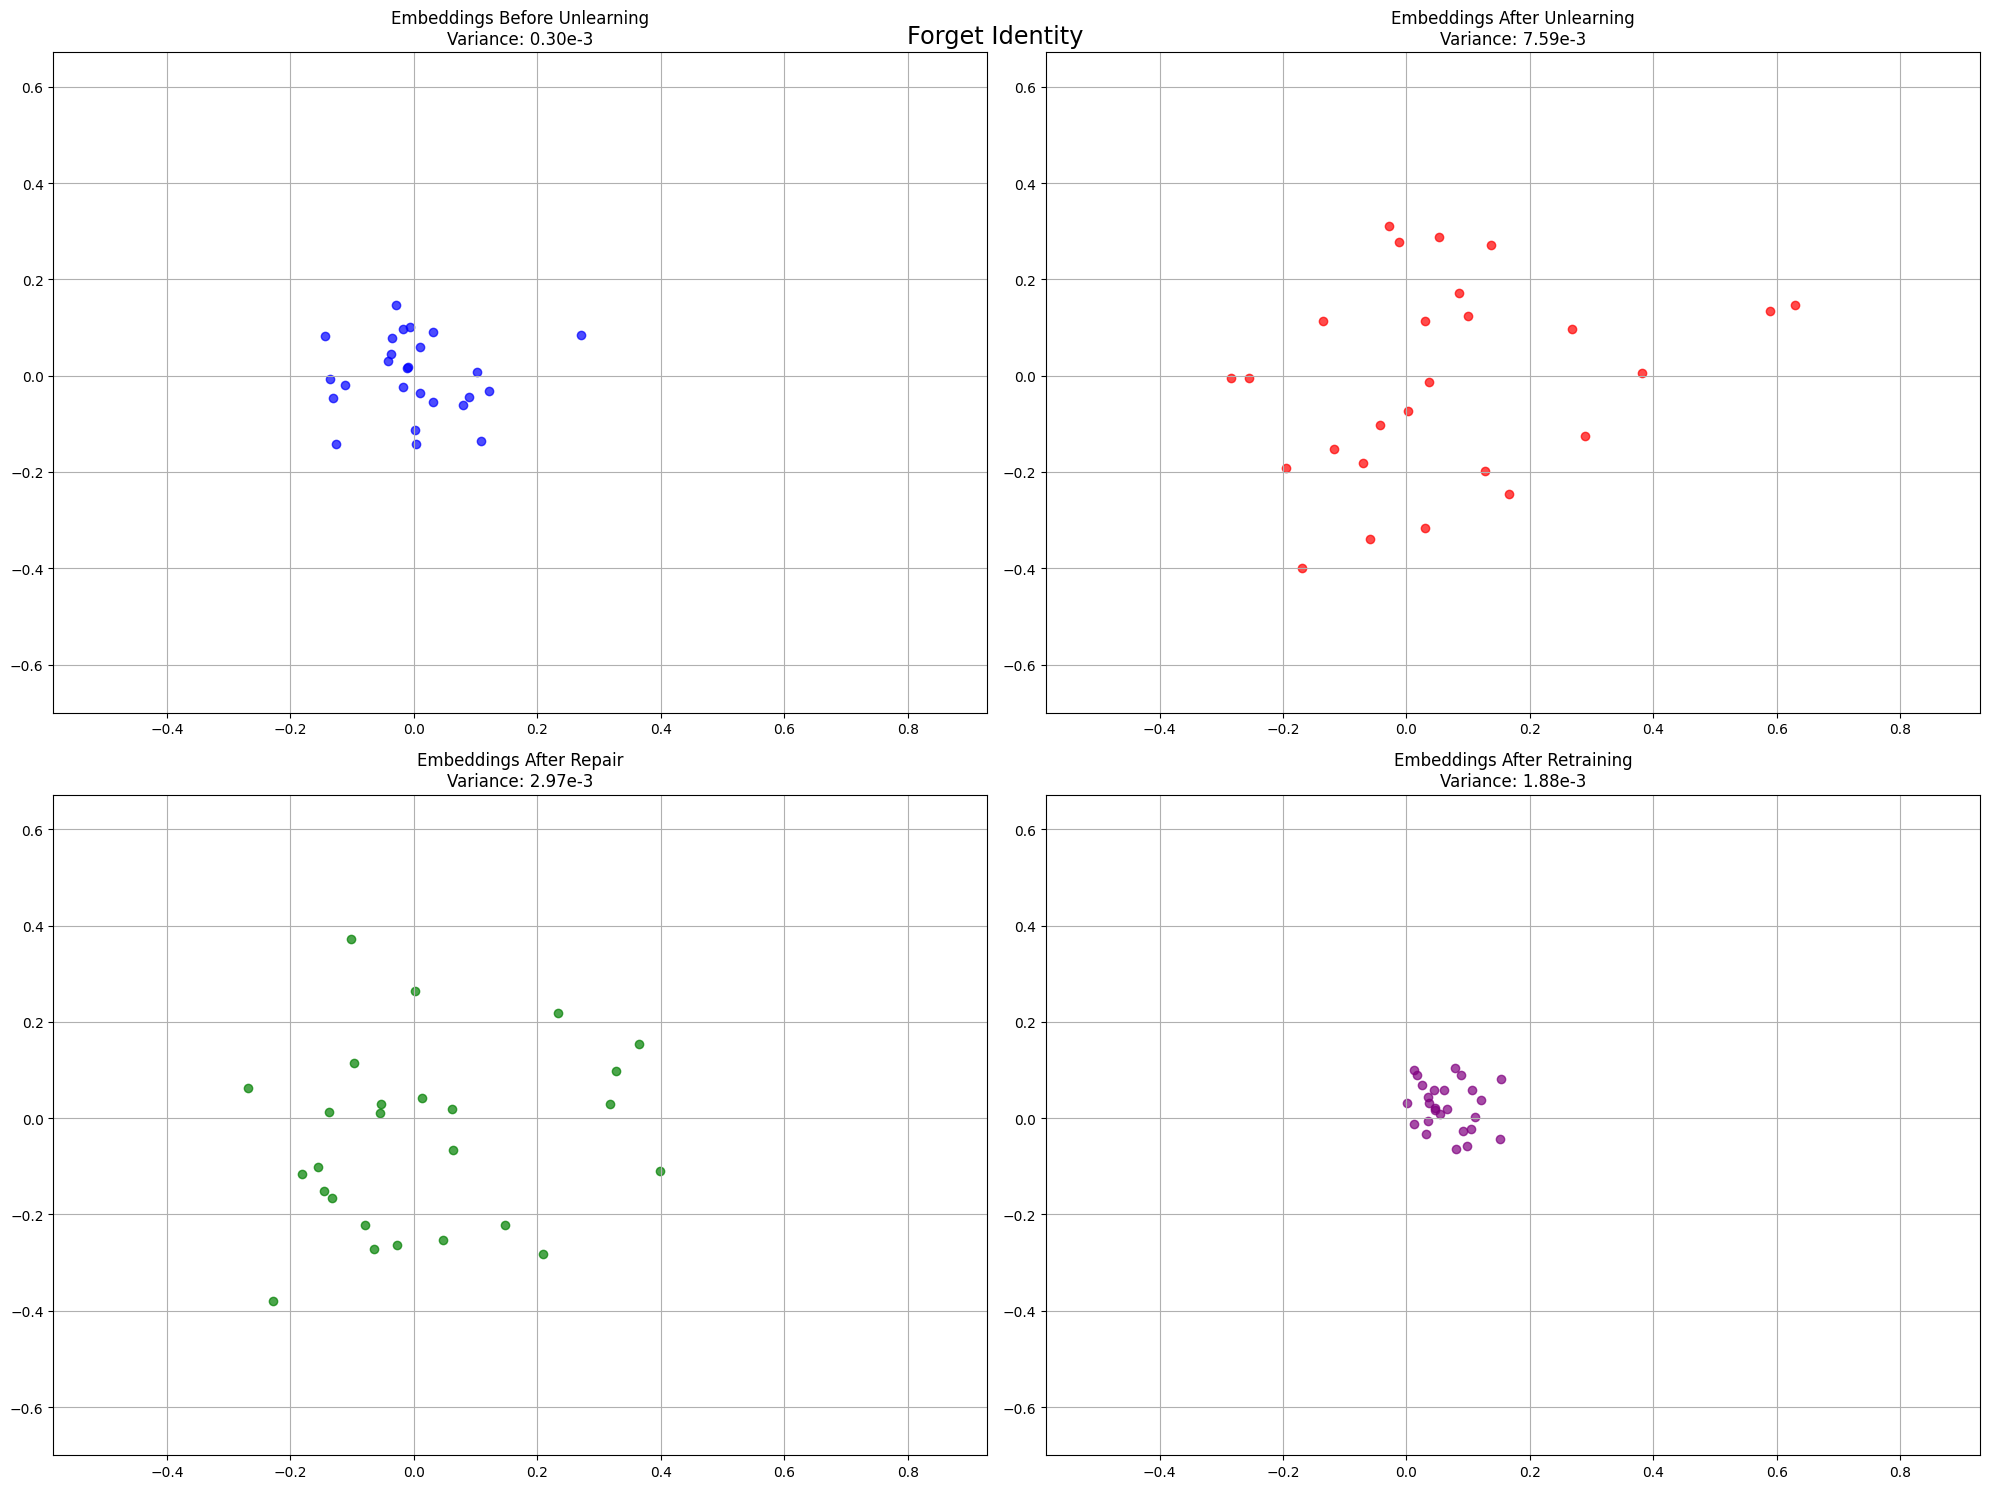

In [158]:
visualize_embeddings(forget_identity, trained_model, unlearned_model, repaired_model, retrained_model, 'Forget Identity', 'Jonas_Images/Clusters_V9_4_2R_Forget')


In [159]:
retain_data_greater_than_three.groupby('labels').count()['path'].sort_values(ascending=False)

labels
1872    530
5458    144
1404    121
373      77
2175     71
       ... 
2080      3
2047      3
2012      3
4316      3
4638      3
Name: path, Length: 646, dtype: int64

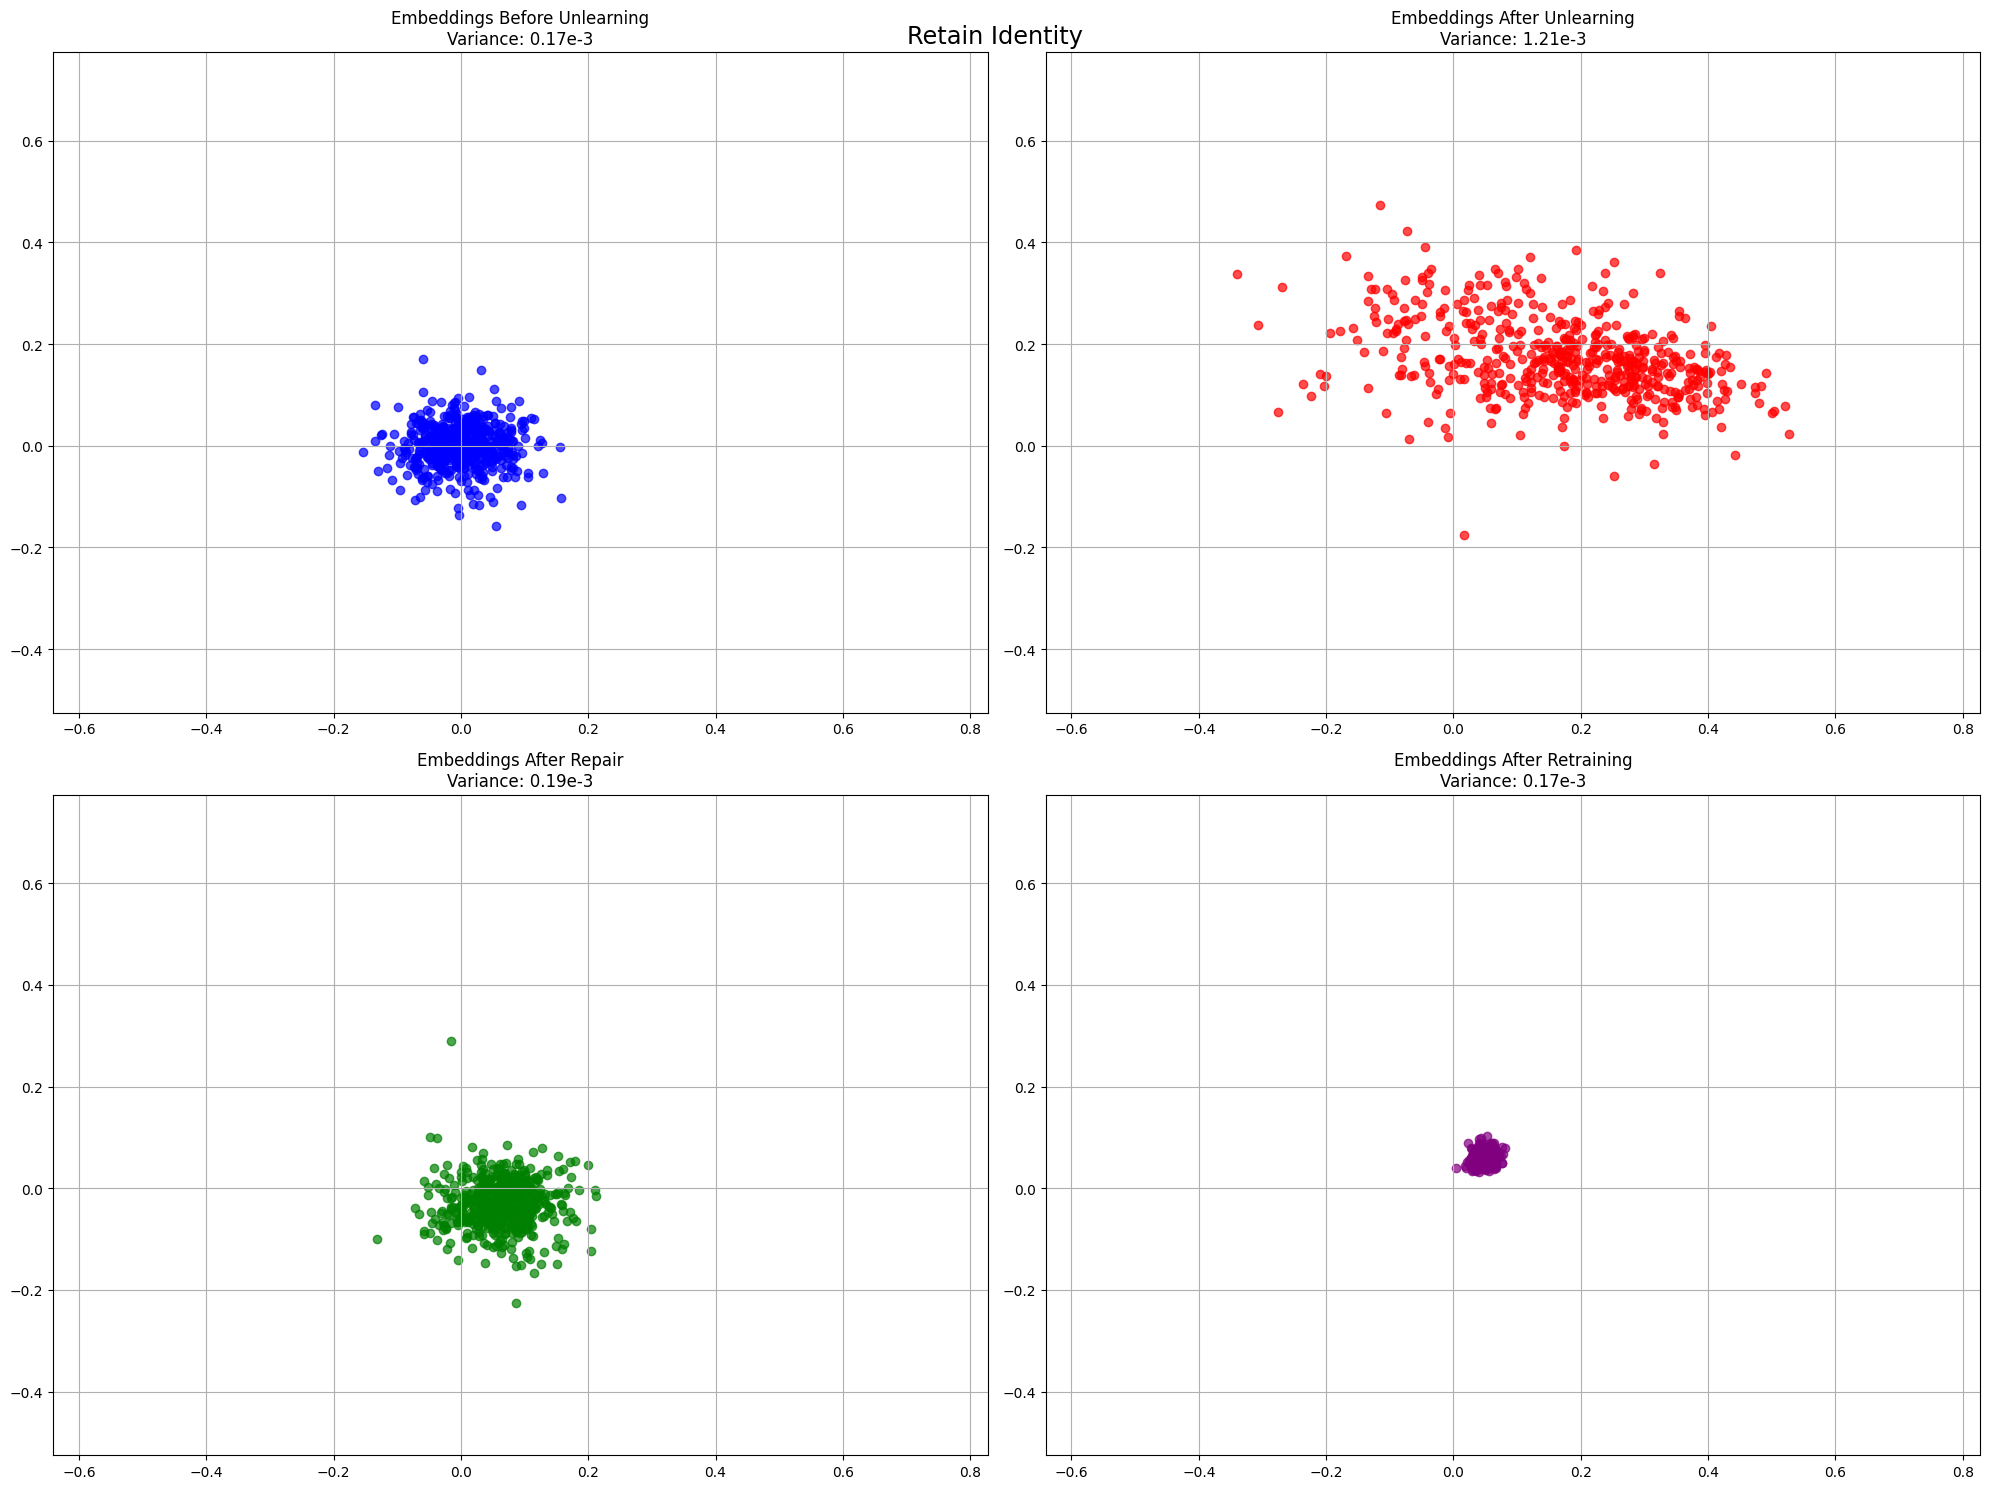

In [160]:
visualize_embeddings(retain_data_greater_than_three[retain_data_greater_than_three['labels']==1872], trained_model, unlearned_model, repaired_model, retrained_model, 'Retain Identity', 'Jonas_Images/Clusters_V9_4_2R_Retain')


In [161]:
test_data_greater_than_three.groupby('labels').count()['path'].sort_values(ascending=False)

labels
1893    109
2045     39
248      36
4572     27
1965     26
       ... 
4428      3
1666      3
2319      3
2241      3
3156      3
Name: path, Length: 168, dtype: int64

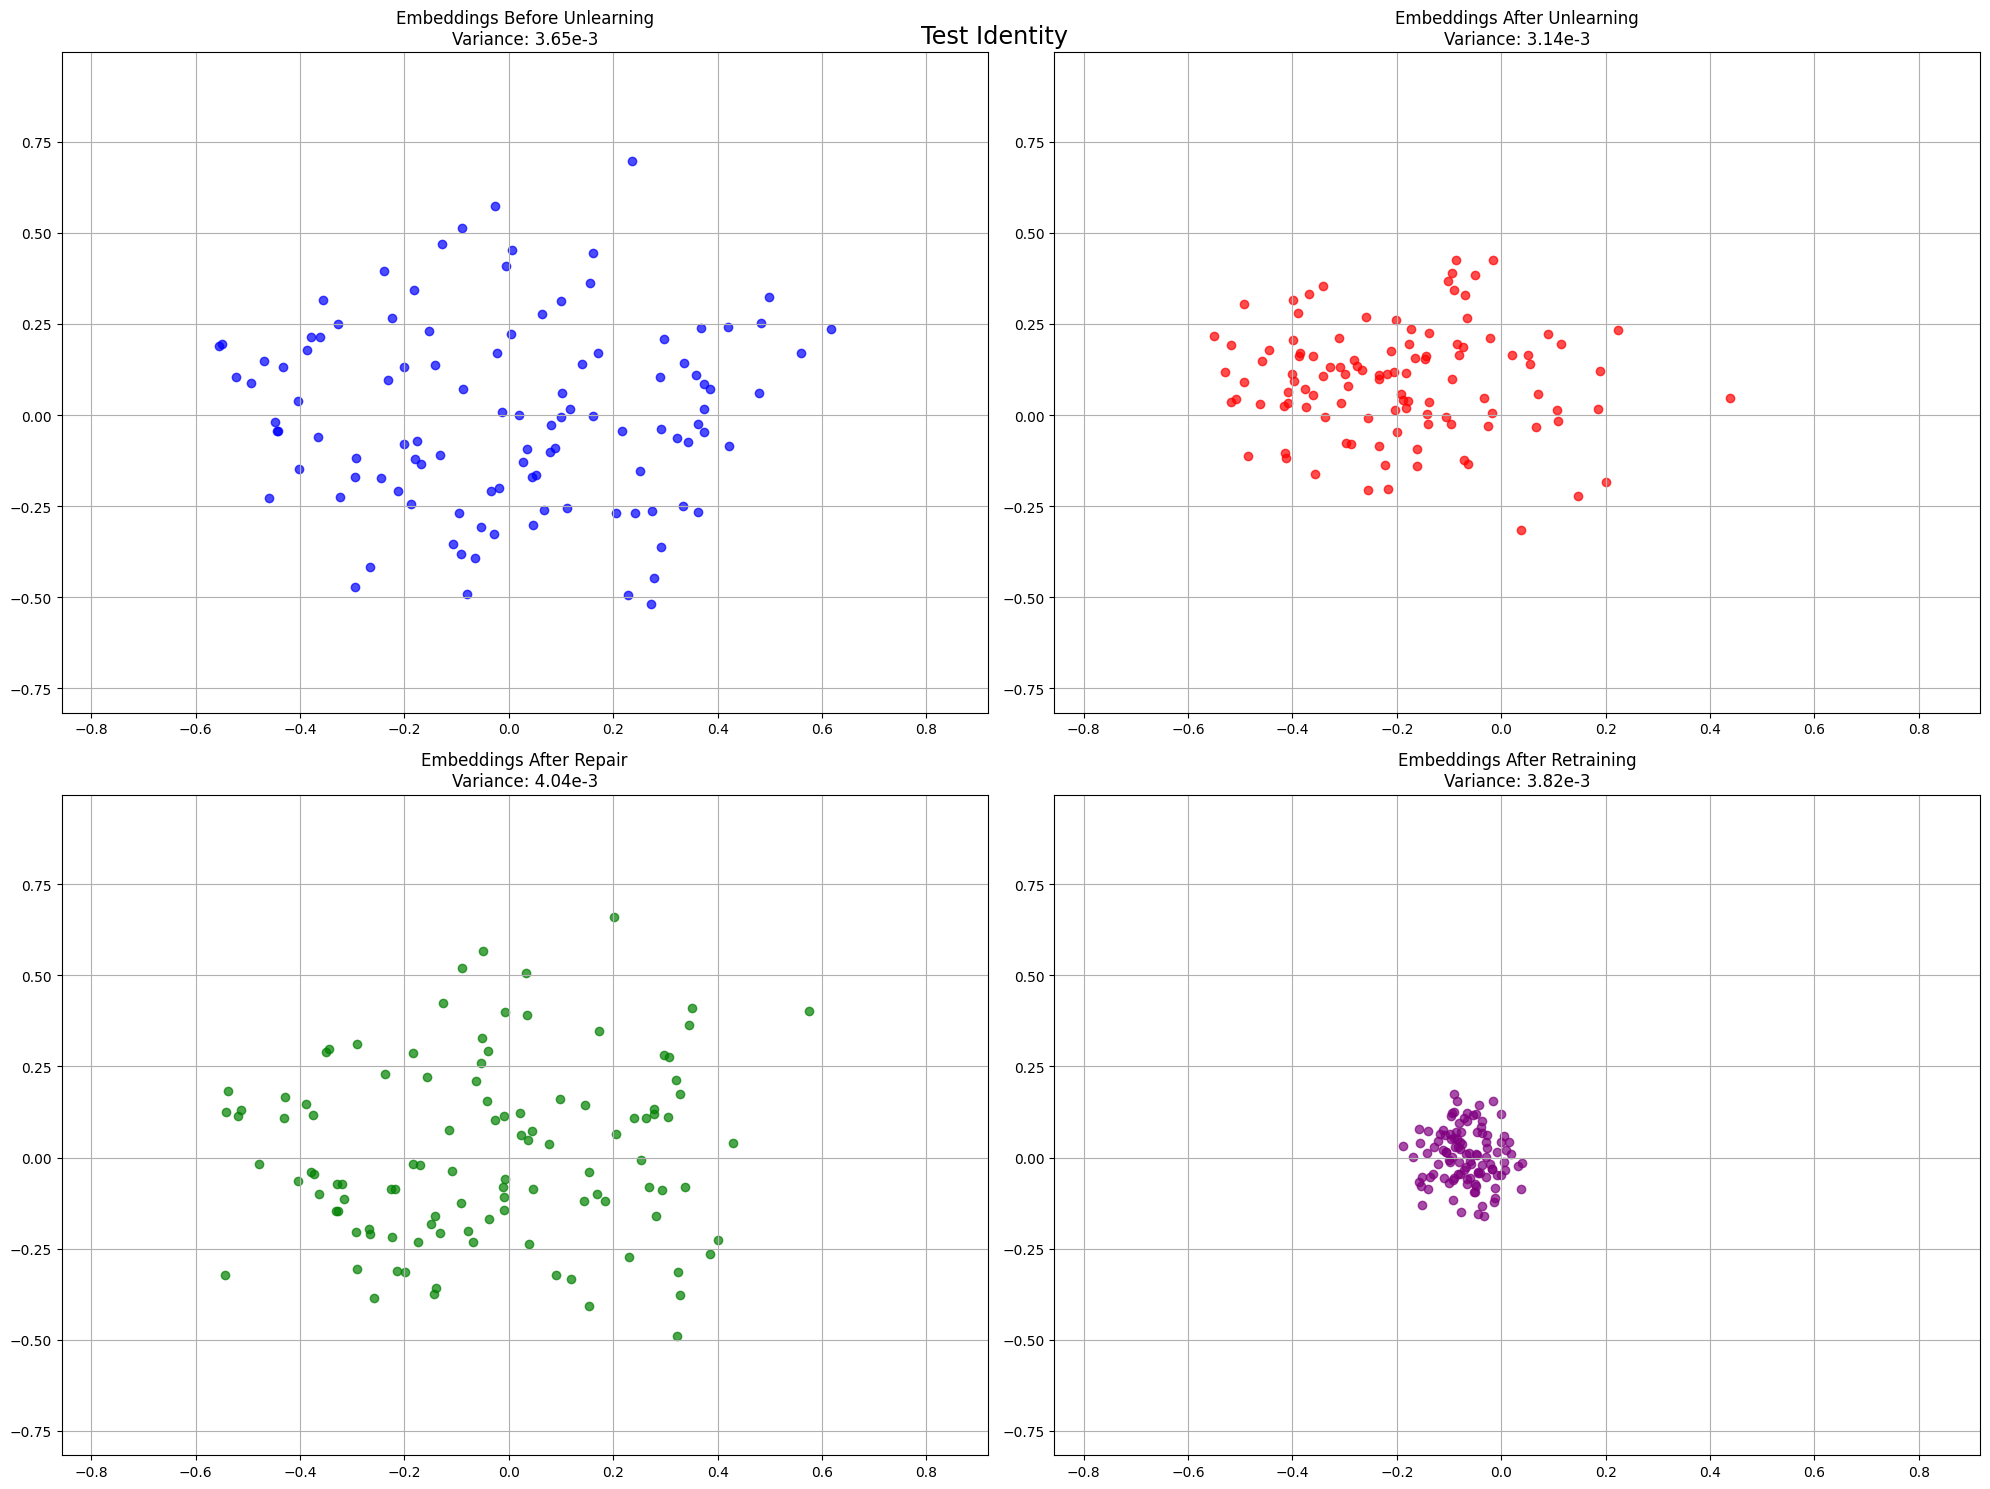

In [162]:
visualize_embeddings(test_data_greater_than_three[test_data_greater_than_three['labels']==1893], trained_model, unlearned_model, repaired_model, retrained_model, 'Test Identity', 'Jonas_Images/Clusters_V9_4_2R_Test')


## Triplet embedding ratios

MSE between Train and Repaired: 0.0183
MSE between Train and Retrained: 0.0529
MSE between Repaired and Retrained: 0.0460


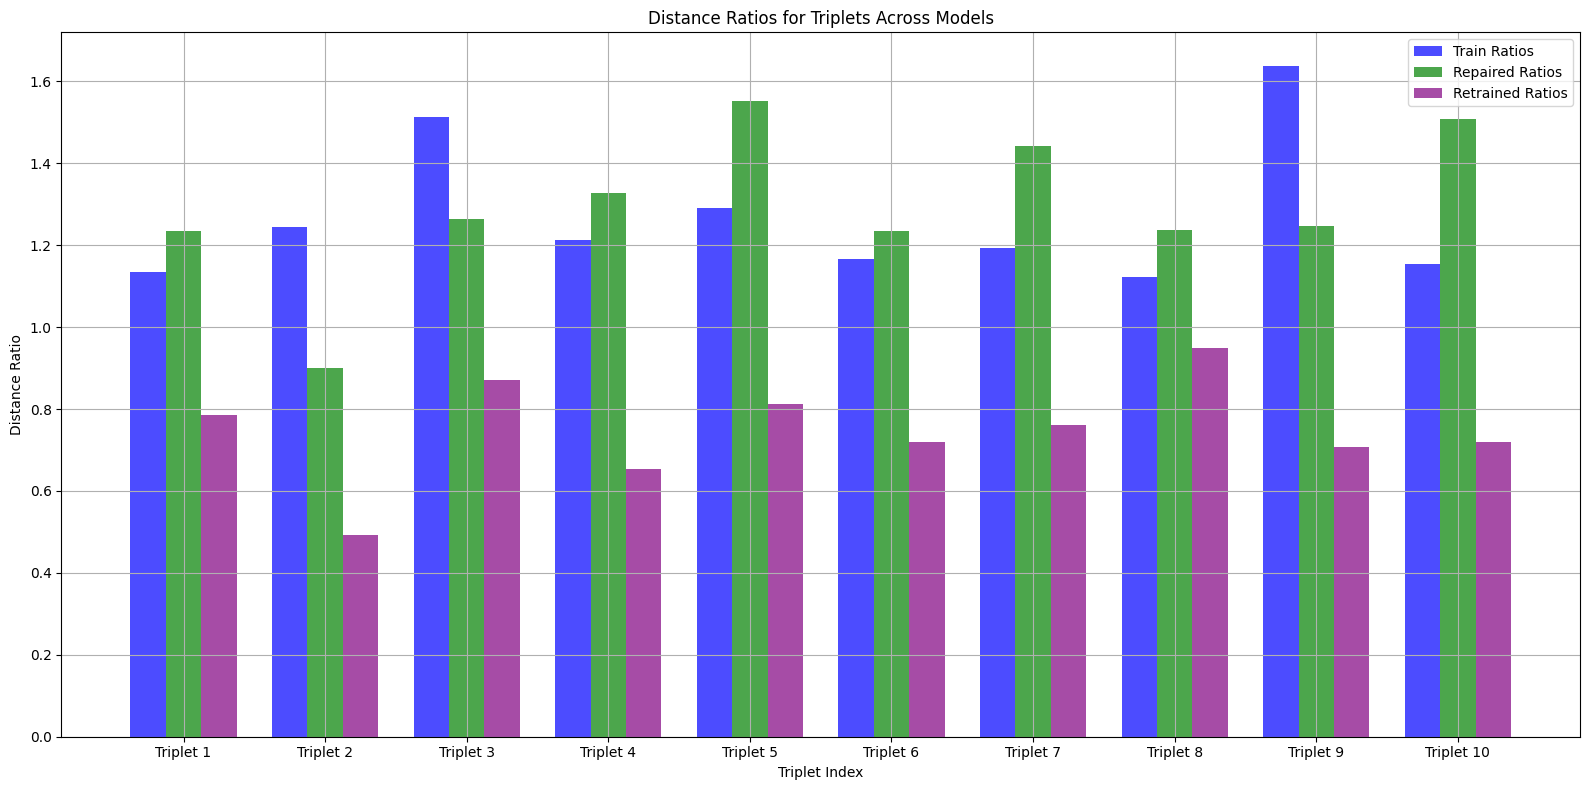

In [190]:
data = pd.concat([forget_identity,test_data_greater_than_three[test_data_greater_than_three['labels'].isin([1893, 2045, 248, 4572])].sample(len(forget_identity)*2, random_state=42)])


compare_triplet_embeddings(
    #forget_identity,
    data,
    trained_model,
    cont_model,
    retrained_model,
    n_plot=10
)

## Tests

In [44]:
# Evaluate on validation data and sample from test + forget
repaired_model1 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
repaired_model1.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.1.pth')))
repaired_model2 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
repaired_model2.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.2.pth')))
repaired_model3 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
repaired_model3.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.3.pth')))
repaired_model4 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
repaired_model4.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.4.pth')))

#  repaired   retrained    trained
#data = pd.concat([forget_identity,test_data_greater_than_three.sample(len(forget_identity)*3, random_state=42)])
#data = pd.concat([forget_identity,test_data_greater_than_three])
# data = forget_identity
# data = test_data_greater_than_three[test_data_greater_than_three['labels']==(1893)]
# data = test_data_greater_than_three
# embeddings_test=get_batch_embeddings(data, repaired_model1, device, batch_size=64)
#accuracy = calculate_accuracy(embeddings_test, data, threshold=1.242)
#print(f'Accuracy on val_data: {accuracy}')
#embeddings_test=get_batch_embeddings(data, repaired_model2, device, batch_size=64)
#accuracy = calculate_accuracy(embeddings_test, data, threshold=1.242)
#print(f'Accuracy on val_data: {accuracy}')
#embeddings_test=get_batch_embeddings(data, repaired_model3, device, batch_size=64)
#accuracy = calculate_accuracy(embeddings_test, data, threshold=1.242)
#print(f'Accuracy on val_data: {accuracy}')
#embeddings_test=get_batch_embeddings(data, repaired_model4, device, batch_size=64)
#accuracy = calculate_accuracy(embeddings_test, data, threshold=1.242)
#print(f'Accuracy on val_data: {accuracy}')

"data = test_data_greater_than_three\nembeddings_test=get_batch_embeddings(data, repaired_model1, device, batch_size=64)\naccuracy = calculate_accuracy(embeddings_test, data, threshold=1.242)\nprint(f'Accuracy on val_data: {accuracy}')\nembeddings_test=get_batch_embeddings(data, repaired_model2, device, batch_size=64)\naccuracy = calculate_accuracy(embeddings_test, data, threshold=1.242)\nprint(f'Accuracy on val_data: {accuracy}')\nembeddings_test=get_batch_embeddings(data, repaired_model3, device, batch_size=64)\naccuracy = calculate_accuracy(embeddings_test, data, threshold=1.242)\nprint(f'Accuracy on val_data: {accuracy}')\nembeddings_test=get_batch_embeddings(data, repaired_model4, device, batch_size=64)\naccuracy = calculate_accuracy(embeddings_test, data, threshold=1.242)\nprint(f'Accuracy on val_data: {accuracy}')"

In [66]:
resnet1 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
resnet2 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
resnet3 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
resnet4 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)

In [38]:
resnet1 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
resnet1.load_state_dict(torch.load(os.path.join(save_dir, 'retrained_model_V0.1.pth')))
resnet2 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
resnet2.load_state_dict(torch.load(os.path.join(save_dir, 'retrained_model_V0.2.pth')))
resnet3 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
resnet3.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.3.pth')))
resnet4 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
resnet4.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.4.pth')))

<All keys matched successfully>

In [51]:
#retain_data_greater_than_three.groupby('labels').count()['path'].sort_values(ascending=False)[0:10]
test_data_greater_than_three.groupby('labels').count()['path'].sort_values(ascending=False)[0:10]

labels
1893    109
2045     39
248      36
4572     27
1965     26
2530     24
4333     22
787      21
223      21
2210     20
Name: path, dtype: int64

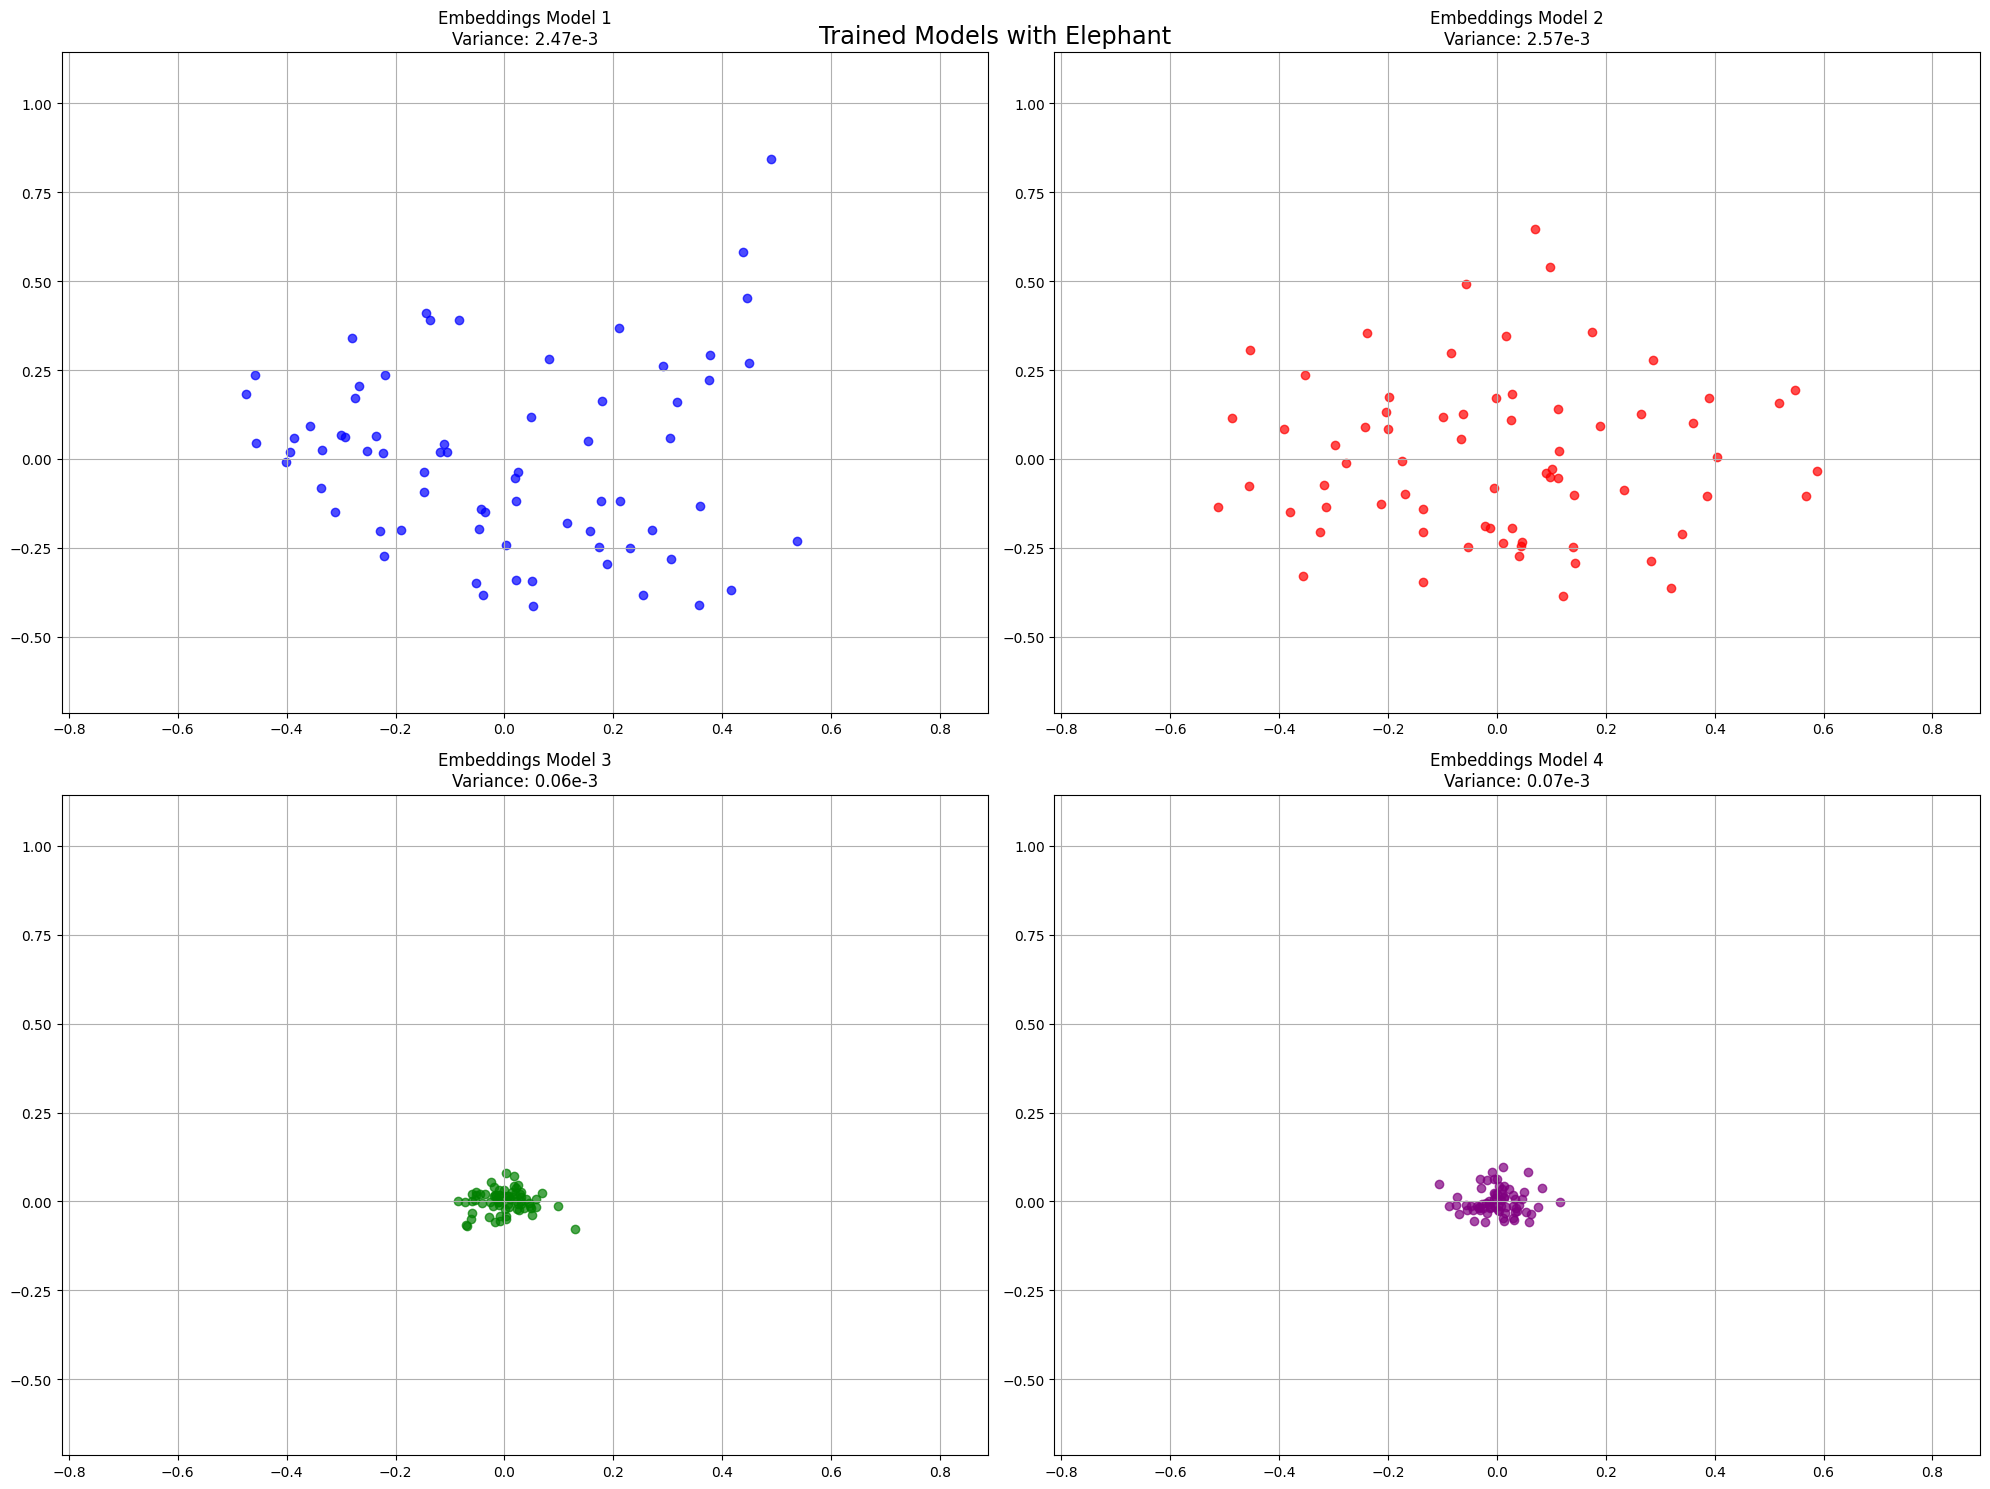

In [78]:
#visualize_embeddings_test(retain_data_greater_than_three[retain_data_greater_than_three['labels']==5458], resnet1, resnet2, resnet3, resnet4, 'Trained Models with Elephant', 'Jonas_Images/Trained_Embeddings_V2_Elephant')
visualize_embeddings_test(forget_identity, resnet1, resnet2, resnet3, resnet4, 'Trained Models with Elephant', 'Jonas_Images/Trained_Embeddings_V2_Elephant')
#visualize_embeddings_test(test_data_greater_than_three[test_data_greater_than_three['labels']==1893], resnet1, resnet2, resnet3, resnet4, 'Trained Models', 'Jonas_Images/Trained_Embeddings_V1_TestID')


MSE between Resnet1 and Resnet2: 0.0135
MSE between Resnet1 and Resnet3: 0.0137
MSE between Resnet2 and Resnet3: 0.0146
MSE between Resnet1 and Resnet4: 0.0159
MSE between Resnet4 and Resnet3: 0.0162
MSE between Resnet2 and Resnet4: 0.0136


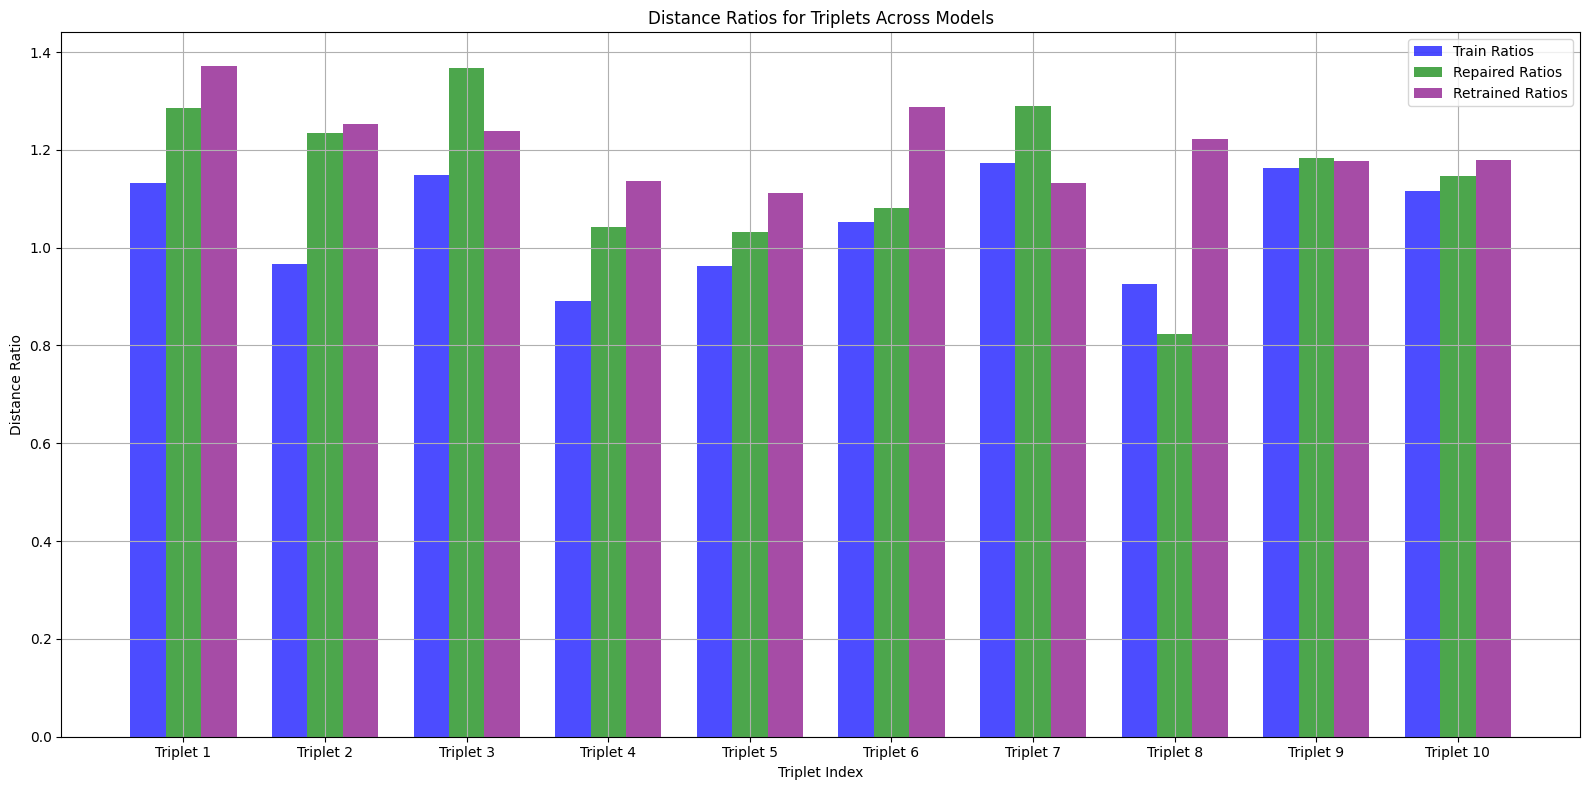

In [45]:
data = pd.concat([forget_identity,test_data_greater_than_three[test_data_greater_than_three['labels'].isin([1893, 2045, 248, 4572])].sample(len(forget_identity)*2, random_state=42)])


compare_triplet_embeddings_test(
    #forget_identity,
    data,
    repaired_model1,
    repaired_model2,
    repaired_model3,
    repaired_model4,
    n_plot=10
)

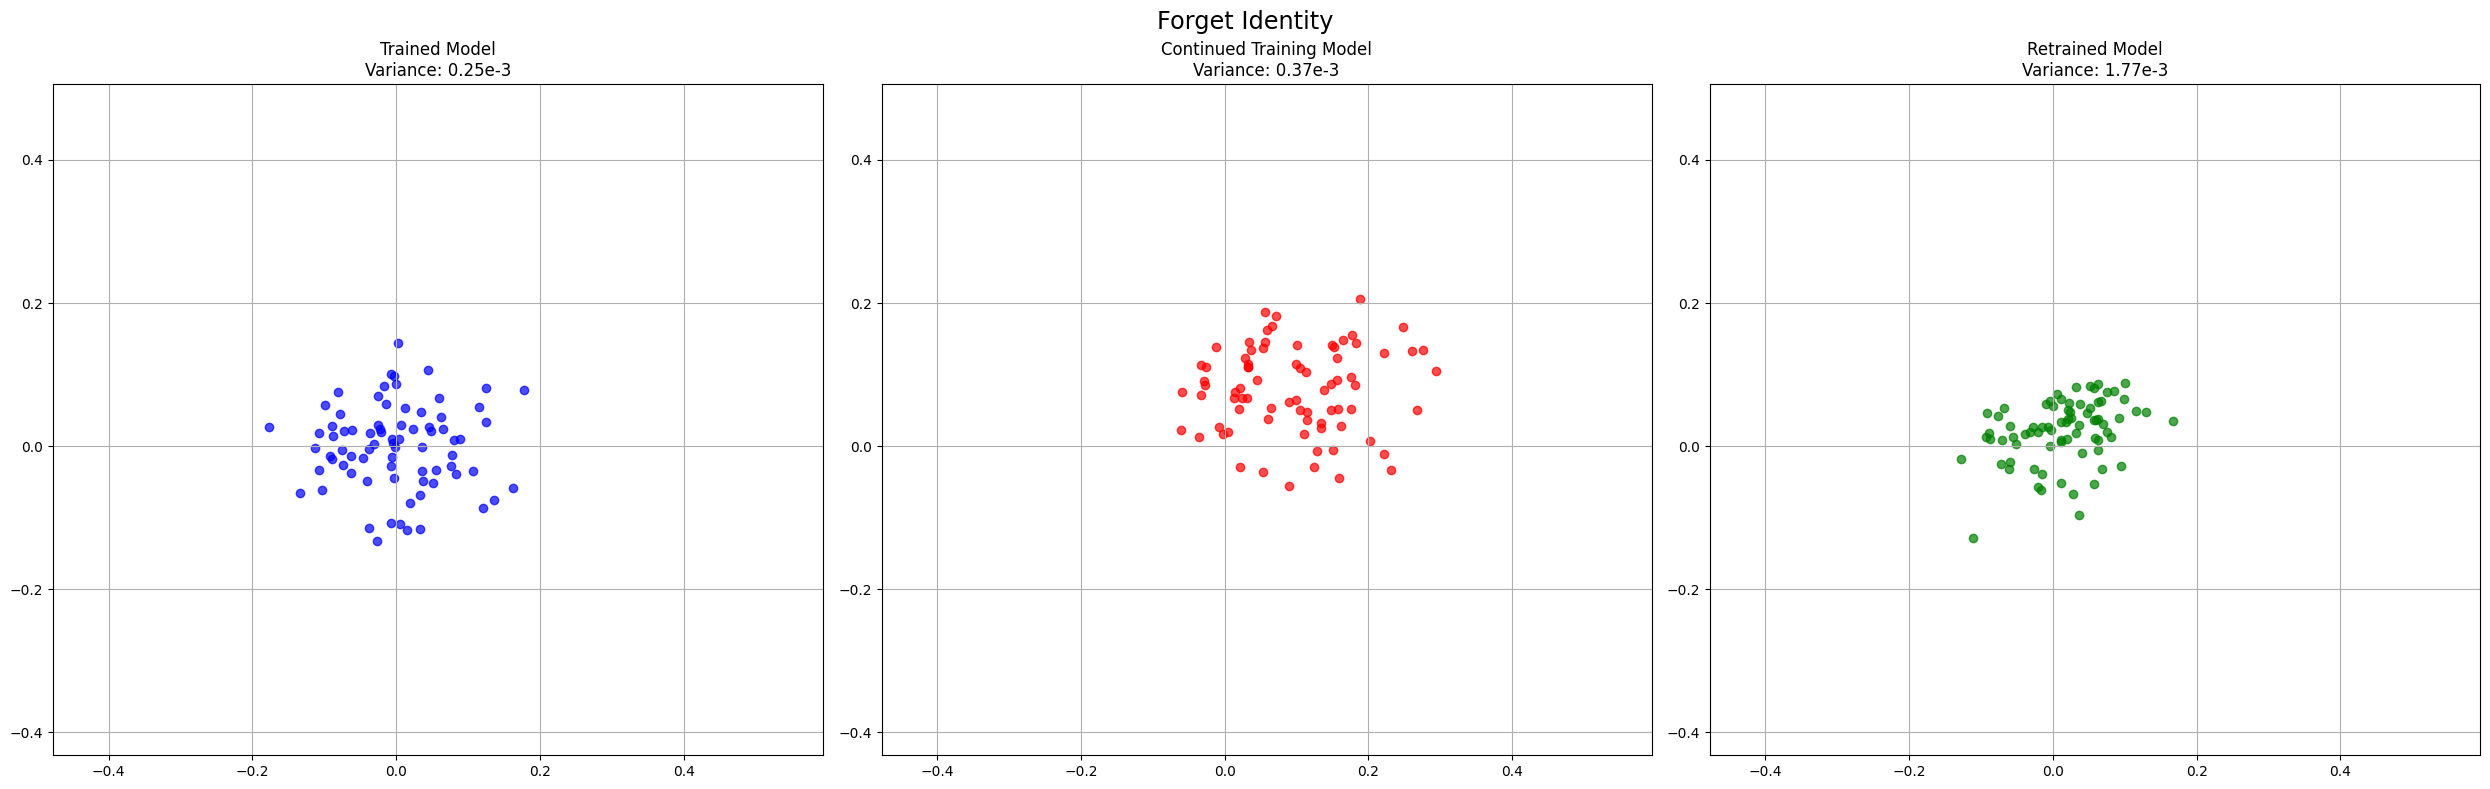

In [459]:
model_1 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
model_2 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
model_3 = CustomInceptionResnet(pretrained='casia-webface', classify=False, device=device).to(device)
model_1.load_state_dict(torch.load(os.path.join(save_dir, 'trained_model_V1.1.pth')))
model_2.load_state_dict(torch.load(os.path.join(save_dir, 'cont_trained_model_V5.1.pth')))
model_3.load_state_dict(torch.load(os.path.join(save_dir, 'retrained_model_V3.1.pth')))

visualize_embeddings_cont(forget_identity, model_1, model_2, model_3, 'Forget Identity', 'Jonas_Images/Clusters_Cont_V5')
